In [2]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import sys
sys.path.append('/content/gdrive/MyDrive/tatter-master/')
sys.path.append('/content/gdrive/MyDrive/tatter-master/tatter/')
from tatter import two_sample_test
import numpy as np
from numpy.random import seed
from numpy.random import normal
from numpy.random import lognormal
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
#!pip install wget

# Introduction to the TATTER software

## Maximum Mean Discrepancy test

First step is to generate two data sets. Each will be 1000 data points drawn from a 1-D Gaussian distribution with different means (0.0 and 0.2) but the same variance (1.0).

In [4]:

  X=normal(loc=0.0, scale=1.0, size=1000)
  #print(X.shape[1])
  Y=normal(loc=0.2, scale=1.0, size=1000)
  #print(Y.shape)
  #gamma = 5.
  XX = X[:, np.newaxis]
YY = Y[:, np.newaxis]

We can now run the two sample test to compare the two probability distributions that were used to generate the data. The arguments for the two sample test are:
- the two data sets
- model: determines what is used to compute the test statisitc (MMD, K-S, K-L)
- iterations - the number of times the test statistic will be computed to generate the test statistic distribution
- if model=MMD, need to define the kernel function that will be used
- if model=MMD, need to specify gamma. It was found in the paper that $\gamma=0.1$ works well
- number of jobs: allows you to parallelize
- verbose = True/False: will show output as code is running
- random_state: used for combination of data sets. Sets it as a value (random_state=None), an array (random_state=integer), or a tuple (random_state=N-Dim array).

The ouput is a value for the test statistic, a null distribution, and an estimated p_value

In [7]:
gamma=.1
sigma2 = np.median(pairwise_distances(XX, YY, metric='euclidean'))**2 * 2.0
mmd2u, mmd2u_null, p_value = two_sample_test(XX, YY,
                           model='MMD',
                           iterations=1000,
                           kernel_function='rbf',
                           gamma=gamma,
                           n_jobs=4,
                           verbose=True,
                           random_state=0)

test value = 0.003346487889645422
Computing the null distribution.


100%|██████████| 1000/1000 [01:54<00:00,  8.75it/s]


p-value < 0.001 	 (resolution : 0.001)


##Using K-S and K-L tests

Example of the computation for the K-S and K-L tests.

In [8]:
ks, ks_null, ks_p_value = two_sample_test(XX, YY, model='KS', iterations=1000,
                                          verbose=True, n_jobs=1)

kl, kl_null, kl_p_value = two_sample_test(XX, YY, model='KL', iterations=1000,
                                          verbose=True, n_jobs=1)


test value = 0.078
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 1280.82it/s]


p-value ~= 0.005 	 (resolution : 0.001)
test value = -0.017803189154464393
Computing the null distribution.


100%|██████████| 1000/1000 [04:35<00:00,  3.63it/s]

p-value ~= 0.584 	 (resolution : 0.001)


## Results of the tests

To see the results of the test, we can plot the null distribution and the value of the $\text{MMD}^2_u$ test or the other test statistics (shown by the del). If the del is not on zero, then the test found that the two data sets were drawn from different distibutions. In the case of this example, we would expect that $\text{MMD}^2_u \neq 0$ as the means are different.

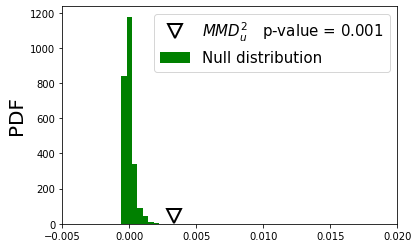

In [9]:
prob, bins, patches = plt.hist(mmd2u_null, range=[-0.005, 0.015], bins=50,
                               density=True, color='green', label='Null distribution')
plt.plot(mmd2u, prob.max()/25, 'wv', markersize=14, markeredgecolor='k',
         markeredgewidth=2, label="$MMD^2_u$   p-value = %0.3f"%p_value)
plt.xlim([-0.005, 0.020])
plt.ylabel('PDF', size=20)
plt.legend(loc=1, numpoints=1, prop={'size':15})

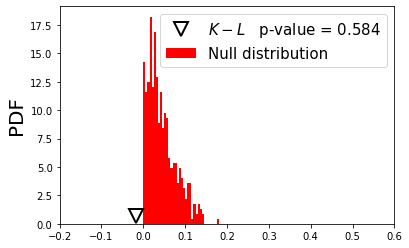

In [13]:
prob, bins, patches = plt.hist(kl_null, range=(0.0, 0.25), bins=50,
                               density=True, color='red', label='Null distribution')
plt.plot(kl, prob.max()/25, 'wv', markersize=14, markeredgecolor='k',
         markeredgewidth=2, label="$K-L$   p-value = %0.3f"%kl_p_value)
plt.xlim([-.2, 0.6])
plt.ylabel('PDF', size=20)
plt.legend(loc=1, numpoints=1, prop={'size':15})

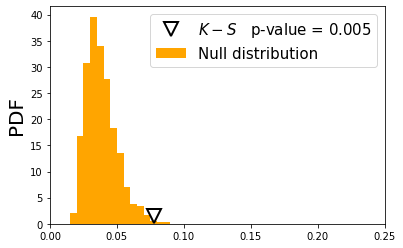

In [12]:
prob, bins, patches = plt.hist(ks_null, range=(0.0, 0.25), bins=50,
                               density=True, color='orange', label='Null distribution')
plt.plot(ks, prob.max()/25, 'wv', markersize=14, markeredgecolor='k',
         markeredgewidth=2, label="$K-S$   p-value = %0.3f"%ks_p_value)
plt.xlim([0.0, 0.25])
plt.ylabel('PDF', size=20)
plt.legend(loc=1, numpoints=1, prop={'size':15})

We find that the K-S test and the MMD test correctly find that the two distributions are different as the value of the test statistics is not zero and falls within the tails of the null distribution. The results of the K-L test are incorrect, but it is known that this test is less reliable.

#Reproducing Results from the Paper

##MMD, K-S, and K-L tests for two samples drawn from 1-D Gaussian probability distributions

Now I want to reproduce the some of the results from the paper. The first was to compare the performance of the three tests for various sample sizes. This was run twice for each test. Once when the two distributions had the same mean (0.0) and once when the two distributions had different means (0.0 and 0.2).

In [5]:
#two arrays to hold the size of the data sets generated and their corresponding p_values
sample_size=[]
p_values_array=[]
rej_rate_array=[]

i=1
#Number of sample sizes used
#a smaller number of iterations was performed for the K-L test as it takes much longer
while i<7:
  #determines value of the sample size
  i_int=i*100
  p_int=0.
  j=0
  rej=0
  #for each sample size, 25 p_values are computed and the average of them is saved
  #This is to make the plot less noisy and follows the process outlined in the paper
  while j<25:
    X=normal(loc=0., scale=1.0, size=i_int)
    
    Y=normal(loc=0., scale=1.0, size=i_int)
    
    gamma=.1
    XX = X[:, np.newaxis]
    YY = Y[:, np.newaxis]

#call the function used to perform the two sample hypothesis test. 
    mmd2u, mmd2u_null, p_value = two_sample_test(XX, YY,
                           model='MMD',
                           kernel_function='rbf',
                           gamma=gamma,
                           iterations=1000,
                           n_jobs=1,
                           verbose=True)
    
    if p_value<.05:
      rej+=1

    p_int+=p_value
    print(j)
    j+=1
  
  avg_p_value=p_int/25.
  reject_rate=rej/25.
  sample_size.append(i_int)
  p_values_array.append(avg_p_value)
  rej_rate_array.append(reject_rate)
  
  i=i+1

#writes all values to a file so that they can be used later
#file1 = open("/content/gdrive/MyDrive/tatter-master/SampleSize_rej.txt", "w")
#np.savetxt(file1, sample_size)
#file1.close()

file2 = open("/content/gdrive/MyDrive/tatter-master/rejRateforMMDTest_samemean.txt", "w")
np.savetxt(file2, rej_rate_array)
file2.close()


test value = -0.0026250605917970127
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2505.65it/s]


p-value ~= 0.8130000000000001 	 (resolution : 0.001)
0
test value = -0.0006656863045089167
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2343.74it/s]


p-value ~= 0.431 	 (resolution : 0.001)
1
test value = -0.0023610132003286655
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2326.36it/s]


p-value ~= 0.768 	 (resolution : 0.001)
2
test value = 0.00453901696153447
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2358.72it/s]


p-value ~= 0.08700000000000001 	 (resolution : 0.001)
3
test value = -0.0015550106433952493
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2445.37it/s]


p-value ~= 0.551 	 (resolution : 0.001)
4
test value = 0.00039558697552166677
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2430.91it/s]


p-value ~= 0.274 	 (resolution : 0.001)
5
test value = 0.0013502242905312212
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2376.90it/s]


p-value ~= 0.221 	 (resolution : 0.001)
6
test value = 8.450758144995518e-05
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2347.31it/s]


p-value ~= 0.322 	 (resolution : 0.001)
7
test value = 0.0016895165688577407
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2639.35it/s]


p-value ~= 0.209 	 (resolution : 0.001)
8
test value = -0.0024595414236754376
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2363.40it/s]


p-value ~= 0.719 	 (resolution : 0.001)
9
test value = 0.0003330800700787062
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2524.74it/s]


p-value ~= 0.294 	 (resolution : 0.001)
10
test value = 0.0008464818775728578
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2174.32it/s]


p-value ~= 0.248 	 (resolution : 0.001)
11
test value = -0.00013365907102169672
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2566.83it/s]


p-value ~= 0.336 	 (resolution : 0.001)
12
test value = 0.007122348844040838
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2566.50it/s]


p-value ~= 0.048 	 (resolution : 0.001)
13
test value = 0.0015198375367189154
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2533.88it/s]


p-value ~= 0.242 	 (resolution : 0.001)
14
test value = 0.0014957517443379142
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2549.49it/s]


p-value ~= 0.20800000000000002 	 (resolution : 0.001)
15
test value = -0.0031459292848163845
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2443.53it/s]


p-value ~= 0.932 	 (resolution : 0.001)
16
test value = 0.018727987065312535
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2613.05it/s]


p-value ~= 0.003 	 (resolution : 0.001)
17
test value = -0.001600819862719316
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2623.88it/s]


p-value ~= 0.577 	 (resolution : 0.001)
18
test value = -0.0010632268524359834
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2506.56it/s]


p-value ~= 0.467 	 (resolution : 0.001)
19
test value = -0.0029713177095744836
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2541.74it/s]


p-value ~= 0.988 	 (resolution : 0.001)
20
test value = -0.0023585380396351496
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2482.82it/s]


p-value ~= 0.746 	 (resolution : 0.001)
21
test value = 0.0008983086932674578
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2513.27it/s]


p-value ~= 0.253 	 (resolution : 0.001)
22
test value = -0.001002914023586321
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2571.26it/s]


p-value ~= 0.464 	 (resolution : 0.001)
23
test value = -0.003188562403367179
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2596.64it/s]


p-value ~= 0.967 	 (resolution : 0.001)
24
test value = -0.00016267490707400079
Computing the null distribution.


100%|██████████| 1000/1000 [00:02<00:00, 468.03it/s]


p-value ~= 0.377 	 (resolution : 0.001)
0
test value = -0.0011884070303247452
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 580.17it/s]


p-value ~= 0.8190000000000001 	 (resolution : 0.001)
1
test value = 0.002224988795852534
Computing the null distribution.


100%|██████████| 1000/1000 [00:02<00:00, 453.73it/s]


p-value ~= 0.09 	 (resolution : 0.001)
2
test value = -0.0013963063393911401
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 504.49it/s]


p-value ~= 0.888 	 (resolution : 0.001)
3
test value = 0.002094067702275826
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 554.86it/s]


p-value ~= 0.092 	 (resolution : 0.001)
4
test value = -0.0005142078720692389
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 513.39it/s]


p-value ~= 0.48 	 (resolution : 0.001)
5
test value = -0.0009358097157678991
Computing the null distribution.


100%|██████████| 1000/1000 [00:02<00:00, 481.73it/s]


p-value ~= 0.627 	 (resolution : 0.001)
6
test value = -0.0012172410893316332
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 514.58it/s]


p-value ~= 0.808 	 (resolution : 0.001)
7
test value = 0.0007323153730818266
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 508.34it/s]


p-value ~= 0.226 	 (resolution : 0.001)
8
test value = -0.0013149067521527336
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 588.17it/s]


p-value ~= 0.8180000000000001 	 (resolution : 0.001)
9
test value = 0.0033446764832043563
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 530.71it/s]


p-value ~= 0.053 	 (resolution : 0.001)
10
test value = -0.001394479934166748
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 502.35it/s]


p-value ~= 0.843 	 (resolution : 0.001)
11
test value = -0.001495879381764098
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 542.85it/s]


p-value ~= 0.995 	 (resolution : 0.001)
12
test value = 0.002464929649597103
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 512.08it/s]


p-value ~= 0.088 	 (resolution : 0.001)
13
test value = 0.0004175169077891283
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 527.98it/s]


p-value ~= 0.262 	 (resolution : 0.001)
14
test value = -0.0006814719108279021
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 547.04it/s]


p-value ~= 0.539 	 (resolution : 0.001)
15
test value = -0.00034222699221087005
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 587.35it/s]


p-value ~= 0.406 	 (resolution : 0.001)
16
test value = -0.001223516301601224
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 553.39it/s]


p-value ~= 0.749 	 (resolution : 0.001)
17
test value = -0.0006606564516671298
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 563.20it/s]


p-value ~= 0.526 	 (resolution : 0.001)
18
test value = 0.006586053010255721
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 610.26it/s]


p-value ~= 0.003 	 (resolution : 0.001)
19
test value = 0.0017252698457566051
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 558.97it/s]


p-value ~= 0.117 	 (resolution : 0.001)
20
test value = 0.00010109106599642814
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 517.99it/s]


p-value ~= 0.35100000000000003 	 (resolution : 0.001)
21
test value = -0.000853304186567927
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 536.69it/s]


p-value ~= 0.606 	 (resolution : 0.001)
22
test value = 0.005947272511245272
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 526.50it/s]


p-value ~= 0.021 	 (resolution : 0.001)
23
test value = -0.001092804440532058
Computing the null distribution.


100%|██████████| 1000/1000 [00:02<00:00, 448.37it/s]


p-value ~= 0.685 	 (resolution : 0.001)
24
test value = -0.0003751450029620962
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 169.50it/s]


p-value ~= 0.518 	 (resolution : 0.001)
0
test value = 0.000538224328791248
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 174.29it/s]


p-value ~= 0.203 	 (resolution : 0.001)
1
test value = 0.002081628414076775
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 171.66it/s]


p-value ~= 0.057 	 (resolution : 0.001)
2
test value = 0.0008620983233429413
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 176.32it/s]


p-value ~= 0.17400000000000002 	 (resolution : 0.001)
3
test value = -0.0006552084888251652
Computing the null distribution.


100%|██████████| 1000/1000 [00:06<00:00, 151.94it/s]


p-value ~= 0.59 	 (resolution : 0.001)
4
test value = -0.0008897424851410651
Computing the null distribution.


100%|██████████| 1000/1000 [00:06<00:00, 162.91it/s]


p-value ~= 0.857 	 (resolution : 0.001)
5
test value = 0.0003580978454382766
Computing the null distribution.


100%|██████████| 1000/1000 [00:06<00:00, 152.58it/s]


p-value ~= 0.214 	 (resolution : 0.001)
6
test value = -5.68279611705691e-05
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 172.01it/s]


p-value ~= 0.333 	 (resolution : 0.001)
7
test value = 0.00013756812119902762
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 170.84it/s]


p-value ~= 0.294 	 (resolution : 0.001)
8
test value = -0.0010560572472744223
Computing the null distribution.


100%|██████████| 1000/1000 [00:06<00:00, 158.98it/s]


p-value ~= 0.991 	 (resolution : 0.001)
9
test value = 0.00020289735347756022
Computing the null distribution.


100%|██████████| 1000/1000 [00:06<00:00, 162.25it/s]


p-value ~= 0.278 	 (resolution : 0.001)
10
test value = -0.0009363620487421453
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 184.47it/s]


p-value ~= 0.846 	 (resolution : 0.001)
11
test value = 0.0003320056543774097
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 177.69it/s]


p-value ~= 0.243 	 (resolution : 0.001)
12
test value = -0.001040253230054855
Computing the null distribution.


100%|██████████| 1000/1000 [00:06<00:00, 152.69it/s]


p-value ~= 0.979 	 (resolution : 0.001)
13
test value = -0.0009472261702561102
Computing the null distribution.


100%|██████████| 1000/1000 [00:07<00:00, 135.57it/s]


p-value ~= 0.8310000000000001 	 (resolution : 0.001)
14
test value = -0.0004140221415225298
Computing the null distribution.


100%|██████████| 1000/1000 [00:07<00:00, 130.55it/s]


p-value ~= 0.522 	 (resolution : 0.001)
15
test value = -0.001073645231988829
Computing the null distribution.


100%|██████████| 1000/1000 [00:07<00:00, 140.30it/s]


p-value ~= 0.99 	 (resolution : 0.001)
16
test value = 0.0014647707538610888
Computing the null distribution.


100%|██████████| 1000/1000 [00:06<00:00, 148.71it/s]


p-value ~= 0.096 	 (resolution : 0.001)
17
test value = -0.0009138536398367592
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 184.53it/s]


p-value ~= 0.9590000000000001 	 (resolution : 0.001)
18
test value = -0.000593909543209703
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 182.63it/s]


p-value ~= 0.614 	 (resolution : 0.001)
19
test value = -3.7375734032174535e-06
Computing the null distribution.


100%|██████████| 1000/1000 [00:06<00:00, 152.83it/s]


p-value ~= 0.352 	 (resolution : 0.001)
20
test value = -0.0004889507541752103
Computing the null distribution.


100%|██████████| 1000/1000 [00:07<00:00, 129.70it/s]


p-value ~= 0.517 	 (resolution : 0.001)
21
test value = -0.0007950385922619319
Computing the null distribution.


100%|██████████| 1000/1000 [00:06<00:00, 153.36it/s]


p-value ~= 0.764 	 (resolution : 0.001)
22
test value = -0.0007458132855624466
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 174.66it/s]


p-value ~= 0.719 	 (resolution : 0.001)
23
test value = 0.00034843912031479185
Computing the null distribution.


100%|██████████| 1000/1000 [00:06<00:00, 161.14it/s]


p-value ~= 0.226 	 (resolution : 0.001)
24
test value = -7.764289513323419e-05
Computing the null distribution.


100%|██████████| 1000/1000 [00:13<00:00, 72.65it/s]


p-value ~= 0.369 	 (resolution : 0.001)
0
test value = -0.0006792304284539696
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 90.18it/s]


p-value ~= 0.805 	 (resolution : 0.001)
1
test value = -0.0006596852207905179
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 85.64it/s]


p-value ~= 0.8180000000000001 	 (resolution : 0.001)
2
test value = -0.0005772731057676062
Computing the null distribution.


100%|██████████| 1000/1000 [00:12<00:00, 79.20it/s]


p-value ~= 0.734 	 (resolution : 0.001)
3
test value = -0.000701328227311615
Computing the null distribution.


100%|██████████| 1000/1000 [00:12<00:00, 78.38it/s]


p-value ~= 0.903 	 (resolution : 0.001)
4
test value = -0.0001371965520848839
Computing the null distribution.


100%|██████████| 1000/1000 [00:12<00:00, 77.58it/s]


p-value ~= 0.389 	 (resolution : 0.001)
5
test value = -0.000244909208779287
Computing the null distribution.


100%|██████████| 1000/1000 [00:15<00:00, 65.02it/s]


p-value ~= 0.439 	 (resolution : 0.001)
6
test value = -0.00025452148186277945
Computing the null distribution.


100%|██████████| 1000/1000 [00:16<00:00, 59.34it/s]


p-value ~= 0.442 	 (resolution : 0.001)
7
test value = 5.740364091799677e-05
Computing the null distribution.


100%|██████████| 1000/1000 [00:17<00:00, 58.80it/s]


p-value ~= 0.305 	 (resolution : 0.001)
8
test value = 0.0007759090262184909
Computing the null distribution.


100%|██████████| 1000/1000 [00:18<00:00, 52.89it/s]


p-value ~= 0.125 	 (resolution : 0.001)
9
test value = -0.00029384436712454054
Computing the null distribution.


100%|██████████| 1000/1000 [00:16<00:00, 59.34it/s]


p-value ~= 0.489 	 (resolution : 0.001)
10
test value = 5.722330873347836e-05
Computing the null distribution.


100%|██████████| 1000/1000 [00:15<00:00, 65.23it/s]


p-value ~= 0.318 	 (resolution : 0.001)
11
test value = -0.0005237144147784978
Computing the null distribution.


100%|██████████| 1000/1000 [00:14<00:00, 67.75it/s]


p-value ~= 0.677 	 (resolution : 0.001)
12
test value = 0.00010044691736954547
Computing the null distribution.


100%|██████████| 1000/1000 [00:13<00:00, 72.84it/s]


p-value ~= 0.296 	 (resolution : 0.001)
13
test value = 0.00016097332648423723
Computing the null distribution.


100%|██████████| 1000/1000 [00:12<00:00, 77.41it/s]


p-value ~= 0.268 	 (resolution : 0.001)
14
test value = -0.00027015984781253444
Computing the null distribution.


100%|██████████| 1000/1000 [00:16<00:00, 59.47it/s]


p-value ~= 0.47400000000000003 	 (resolution : 0.001)
15
test value = 0.0006407566712400836
Computing the null distribution.


100%|██████████| 1000/1000 [00:15<00:00, 65.35it/s]


p-value ~= 0.17300000000000001 	 (resolution : 0.001)
16
test value = 0.00032409248866782647
Computing the null distribution.


100%|██████████| 1000/1000 [00:15<00:00, 65.97it/s]


p-value ~= 0.218 	 (resolution : 0.001)
17
test value = 0.00019526268197589403
Computing the null distribution.


100%|██████████| 1000/1000 [00:16<00:00, 60.74it/s]


p-value ~= 0.264 	 (resolution : 0.001)
18
test value = -0.0005147504818550086
Computing the null distribution.


100%|██████████| 1000/1000 [00:13<00:00, 71.49it/s]


p-value ~= 0.669 	 (resolution : 0.001)
19
test value = 0.0006813200234623285
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 84.23it/s]


p-value ~= 0.157 	 (resolution : 0.001)
20
test value = -0.0003184881981614929
Computing the null distribution.


100%|██████████| 1000/1000 [00:12<00:00, 82.63it/s]


p-value ~= 0.542 	 (resolution : 0.001)
21
test value = -0.0006590131541477362
Computing the null distribution.


100%|██████████| 1000/1000 [00:13<00:00, 75.86it/s]


p-value ~= 0.856 	 (resolution : 0.001)
22
test value = -0.0006006633692210439
Computing the null distribution.


100%|██████████| 1000/1000 [00:16<00:00, 61.53it/s]


p-value ~= 0.8160000000000001 	 (resolution : 0.001)
23
test value = 0.0013477214001775817
Computing the null distribution.


100%|██████████| 1000/1000 [00:12<00:00, 79.93it/s]


p-value ~= 0.062 	 (resolution : 0.001)
24
test value = -0.00038703455224475825
Computing the null distribution.


100%|██████████| 1000/1000 [00:24<00:00, 40.69it/s]


p-value ~= 0.663 	 (resolution : 0.001)
0
test value = -0.0003380897188156595
Computing the null distribution.


100%|██████████| 1000/1000 [00:24<00:00, 40.47it/s]


p-value ~= 0.5750000000000001 	 (resolution : 0.001)
1
test value = 0.0007702427032267867
Computing the null distribution.


100%|██████████| 1000/1000 [00:23<00:00, 41.98it/s]


p-value ~= 0.11900000000000001 	 (resolution : 0.001)
2
test value = 0.0010452914413532355
Computing the null distribution.


100%|██████████| 1000/1000 [00:25<00:00, 39.60it/s]


p-value ~= 0.095 	 (resolution : 0.001)
3
test value = 0.0018023032519638438
Computing the null distribution.


100%|██████████| 1000/1000 [00:22<00:00, 45.40it/s]


p-value ~= 0.033 	 (resolution : 0.001)
4
test value = -0.0005821473229745688
Computing the null distribution.


100%|██████████| 1000/1000 [00:25<00:00, 39.23it/s]


p-value ~= 0.9480000000000001 	 (resolution : 0.001)
5
test value = -0.0002050592334579271
Computing the null distribution.


100%|██████████| 1000/1000 [00:22<00:00, 43.56it/s]


p-value ~= 0.448 	 (resolution : 0.001)
6
test value = -0.0005208617240624047
Computing the null distribution.


100%|██████████| 1000/1000 [00:21<00:00, 45.70it/s]


p-value ~= 0.844 	 (resolution : 0.001)
7
test value = -0.00020538250964774463
Computing the null distribution.


100%|██████████| 1000/1000 [00:24<00:00, 41.42it/s]


p-value ~= 0.468 	 (resolution : 0.001)
8
test value = 0.0018132145480771467
Computing the null distribution.


100%|██████████| 1000/1000 [00:21<00:00, 46.53it/s]


p-value ~= 0.032 	 (resolution : 0.001)
9
test value = -0.0005212909148677447
Computing the null distribution.


100%|██████████| 1000/1000 [00:23<00:00, 42.22it/s]


p-value ~= 0.847 	 (resolution : 0.001)
10
test value = 0.0004386336634285559
Computing the null distribution.


100%|██████████| 1000/1000 [00:24<00:00, 40.84it/s]


p-value ~= 0.182 	 (resolution : 0.001)
11
test value = -0.000284392965734348
Computing the null distribution.


100%|██████████| 1000/1000 [00:22<00:00, 45.32it/s]


p-value ~= 0.529 	 (resolution : 0.001)
12
test value = -4.93742628706606e-05
Computing the null distribution.


100%|██████████| 1000/1000 [00:22<00:00, 43.58it/s]


p-value ~= 0.381 	 (resolution : 0.001)
13
test value = -0.0002047785154601911
Computing the null distribution.


100%|██████████| 1000/1000 [00:23<00:00, 41.78it/s]


p-value ~= 0.451 	 (resolution : 0.001)
14
test value = -0.0003551516752651196
Computing the null distribution.


100%|██████████| 1000/1000 [00:24<00:00, 40.25it/s]


p-value ~= 0.634 	 (resolution : 0.001)
15
test value = -0.00042395449286014575
Computing the null distribution.


100%|██████████| 1000/1000 [00:24<00:00, 41.50it/s]


p-value ~= 0.68 	 (resolution : 0.001)
16
test value = 0.0006224947149722215
Computing the null distribution.


100%|██████████| 1000/1000 [00:23<00:00, 43.14it/s]


p-value ~= 0.138 	 (resolution : 0.001)
17
test value = -0.00023410130227285997
Computing the null distribution.


100%|██████████| 1000/1000 [00:25<00:00, 39.69it/s]


p-value ~= 0.482 	 (resolution : 0.001)
18
test value = 0.0007316786140219023
Computing the null distribution.


100%|██████████| 1000/1000 [00:25<00:00, 38.90it/s]


p-value ~= 0.113 	 (resolution : 0.001)
19
test value = 0.00010996995528533837
Computing the null distribution.


100%|██████████| 1000/1000 [00:24<00:00, 40.21it/s]


p-value ~= 0.263 	 (resolution : 0.001)
20
test value = -0.000575752792699058
Computing the null distribution.


100%|██████████| 1000/1000 [00:23<00:00, 42.36it/s]


p-value ~= 0.9590000000000001 	 (resolution : 0.001)
21
test value = 0.0001552861719389398
Computing the null distribution.


100%|██████████| 1000/1000 [00:22<00:00, 44.62it/s]


p-value ~= 0.255 	 (resolution : 0.001)
22
test value = -0.0004256346378435083
Computing the null distribution.


100%|██████████| 1000/1000 [00:22<00:00, 45.00it/s]


p-value ~= 0.679 	 (resolution : 0.001)
23
test value = 0.0002320488672198362
Computing the null distribution.


100%|██████████| 1000/1000 [00:24<00:00, 41.58it/s]


p-value ~= 0.252 	 (resolution : 0.001)
24
test value = -7.094701262255754e-05
Computing the null distribution.


100%|██████████| 1000/1000 [00:42<00:00, 23.75it/s]


p-value ~= 0.377 	 (resolution : 0.001)
0
test value = -0.00043455943452919144
Computing the null distribution.


100%|██████████| 1000/1000 [00:41<00:00, 24.25it/s]


p-value ~= 0.86 	 (resolution : 0.001)
1
test value = -0.0004609472241157153
Computing the null distribution.


100%|██████████| 1000/1000 [00:42<00:00, 23.59it/s]


p-value ~= 0.868 	 (resolution : 0.001)
2
test value = -0.00048634071380670996
Computing the null distribution.


100%|██████████| 1000/1000 [00:39<00:00, 25.36it/s]


p-value ~= 0.9540000000000001 	 (resolution : 0.001)
3
test value = -0.0003205245411670443
Computing the null distribution.


100%|██████████| 1000/1000 [00:41<00:00, 24.13it/s]


p-value ~= 0.668 	 (resolution : 0.001)
4
test value = -7.471723684537857e-05
Computing the null distribution.


100%|██████████| 1000/1000 [00:38<00:00, 26.06it/s]


p-value ~= 0.379 	 (resolution : 0.001)
5
test value = -2.222865424261755e-05
Computing the null distribution.


100%|██████████| 1000/1000 [00:40<00:00, 24.83it/s]


p-value ~= 0.34900000000000003 	 (resolution : 0.001)
6
test value = 0.00041638164962365387
Computing the null distribution.


100%|██████████| 1000/1000 [00:37<00:00, 26.95it/s]


p-value ~= 0.149 	 (resolution : 0.001)
7
test value = -0.0004066535091196144
Computing the null distribution.


100%|██████████| 1000/1000 [00:40<00:00, 24.96it/s]


p-value ~= 0.769 	 (resolution : 0.001)
8
test value = -0.0004287535354887684
Computing the null distribution.


100%|██████████| 1000/1000 [00:40<00:00, 24.47it/s]


p-value ~= 0.872 	 (resolution : 0.001)
9
test value = -0.00047973953674662617
Computing the null distribution.


100%|██████████| 1000/1000 [00:39<00:00, 25.23it/s]


p-value ~= 0.964 	 (resolution : 0.001)
10
test value = 0.0020511617249143743
Computing the null distribution.


100%|██████████| 1000/1000 [00:38<00:00, 25.92it/s]


p-value ~= 0.015 	 (resolution : 0.001)
11
test value = 0.0005901525712297406
Computing the null distribution.


100%|██████████| 1000/1000 [00:40<00:00, 24.74it/s]


p-value ~= 0.127 	 (resolution : 0.001)
12
test value = -0.00045258839656292515
Computing the null distribution.


100%|██████████| 1000/1000 [00:41<00:00, 24.36it/s]


p-value ~= 0.877 	 (resolution : 0.001)
13
test value = 0.0010558235735032007
Computing the null distribution.


100%|██████████| 1000/1000 [00:38<00:00, 26.21it/s]


p-value ~= 0.059000000000000004 	 (resolution : 0.001)
14
test value = -0.0003082419372986145
Computing the null distribution.


100%|██████████| 1000/1000 [00:38<00:00, 26.19it/s]


p-value ~= 0.615 	 (resolution : 0.001)
15
test value = -0.0004891097184058779
Computing the null distribution.


100%|██████████| 1000/1000 [00:39<00:00, 25.59it/s]


p-value ~= 0.878 	 (resolution : 0.001)
16
test value = -0.00044348005108574284
Computing the null distribution.


100%|██████████| 1000/1000 [00:36<00:00, 27.26it/s]


p-value ~= 0.873 	 (resolution : 0.001)
17
test value = -0.0002802847465386282
Computing the null distribution.


100%|██████████| 1000/1000 [00:38<00:00, 26.08it/s]


p-value ~= 0.61 	 (resolution : 0.001)
18
test value = -0.0004858125213267339
Computing the null distribution.


100%|██████████| 1000/1000 [00:38<00:00, 25.71it/s]


p-value ~= 0.9400000000000001 	 (resolution : 0.001)
19
test value = -0.0004083127775857953
Computing the null distribution.


100%|██████████| 1000/1000 [00:42<00:00, 23.39it/s]


p-value ~= 0.796 	 (resolution : 0.001)
20
test value = -0.00010777468218603481
Computing the null distribution.


100%|██████████| 1000/1000 [00:41<00:00, 24.29it/s]


p-value ~= 0.42 	 (resolution : 0.001)
21
test value = 1.14320887756314e-06
Computing the null distribution.


100%|██████████| 1000/1000 [00:39<00:00, 25.12it/s]


p-value ~= 0.314 	 (resolution : 0.001)
22
test value = 0.0016027681106232095
Computing the null distribution.


100%|██████████| 1000/1000 [00:37<00:00, 26.91it/s]


p-value ~= 0.031 	 (resolution : 0.001)
23
test value = -0.0003871234852785843
Computing the null distribution.


100%|██████████| 1000/1000 [00:38<00:00, 26.14it/s]

p-value ~= 0.788 	 (resolution : 0.001)
24


Now to plot the results

In [4]:
#saves data from files to an array
p_KS_diffmean=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/pValueforKSTest_diffmean_test.txt').transpose()
p_KS_samemean=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/pValueforKSTest_samemean_test.txt').transpose()

p_MMD_diffmean=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/pValueforMMDTest.txt').transpose()
p_MMD_samemean=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/pValueforMMDTest_samemean.txt').transpose()

p_KL_diffmean=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/pValueforKLTest_diffmean.txt').transpose()
p_KL_samemean=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/pValueforKLTest_samemean.txt').transpose()

rej_rate_MMD_samemean=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/rejRateforMMDTest_samemean.txt').transpose()
rej_rate_KS_samemean=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/rejRateforKSTest_samemean.txt').transpose()
rej_rate_KL_samemean=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/rejRateforKLTest_samemean.txt').transpose()

rej_rate_MMD_diffmean=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/rejRateforMMDTest_diffmean.txt').transpose()
rej_rate_KS_diffmean=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/rejRateforKSTest_diffmean.txt').transpose()
rej_rate_KL_diffmean=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/rejRateforKLTest_diffmean.txt').transpose()
sample_rej=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/SampleSize_rej.txt').transpose()

sample=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/SampleSizeFinal.txt').transpose()
KL_sample=np.array([100.,200.,300.,400.,500.])


###Same Mean

Average p_value when the distributions have the same mean

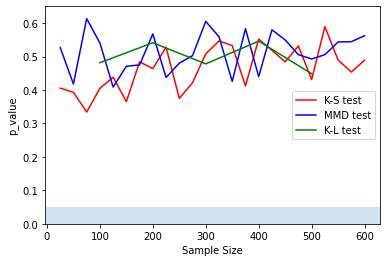

In [ ]:
plt.plot(sample,p_KS_samemean,color='red',label='K-S test')
plt.plot(sample,p_MMD_samemean,color='blue',label='MMD test')
plt.plot(KL_sample,p_KL_samemean,color='green',label='K-L test')
plt.axhspan(0., 0.05, alpha=0.2)
plt.xlabel('Sample Size')
plt.ylabel('p_value')
plt.ylim([0,.65])
plt.legend()

The results of all tests are similar. They all find that the distributions are the same as the p-value is never low enough to reject the null hypothesis.

The plot below shows the rejection rate for all three tests as a function of sample size. A larger rejection rate means that a p_value that was low enough to reject the null hypothesis was found more often when performing the test many times. For two Gaussian distributions with the same mean, we would expect a low (or zero) rejection rate. We see that below. The gray region corresponds to a rejection rate of less than 0.05%.

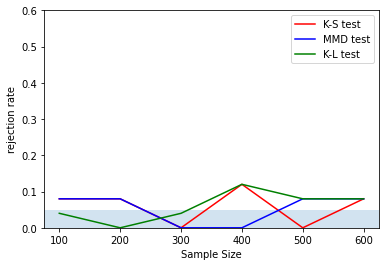

In [5]:
plt.plot(sample_rej,rej_rate_KS_samemean,color='red',label='K-S test')
plt.plot(sample_rej,rej_rate_MMD_samemean,color='blue',label='MMD test')
plt.plot(sample_rej,rej_rate_KL_samemean,color='green',label='K-L test')
plt.axhspan(0., 0.05, alpha=0.2)
plt.xlabel('Sample Size')
plt.ylabel('rejection rate')
plt.ylim([0,.6])
plt.legend()

###Different Mean

Average p_value when distributions have different means.

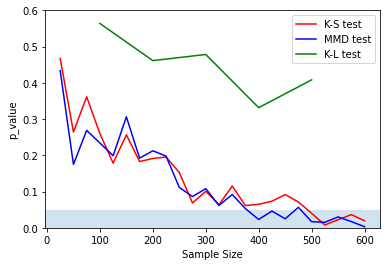

In [ ]:
plt.plot(sample,p_KS_diffmean,color='red',label='K-S test')
plt.plot(sample,p_MMD_diffmean,color='blue',label='MMD test')
plt.plot(KL_sample,p_KL_diffmean,color='green',label='K-L test')
plt.axhspan(0., 0.05, alpha=0.2)
plt.xlabel('Sample Size')
plt.ylabel('p_value')
plt.ylim([0,.6])
plt.legend()

Here we see that the performance of the MDD and K-S tests are similar. At sample sizes of ~400 the two sample test returns a p_value less than .05 (gray shaded region) correctly concluding that the two Gaussian distributions are different.

The rejection rate for two Gaussian distributions with different means. The plot corresponds to what we would expect from above. The rejection rate is higher for the MMD and K-S tests as the sample size increases implying that the tests are often correctly rejecting the null hypothesis.

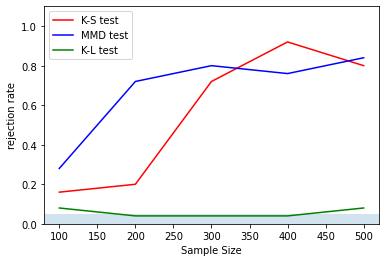

In [6]:
plt.plot(KL_sample,rej_rate_KS_diffmean,color='red',label='K-S test')
plt.plot(KL_sample,rej_rate_MMD_diffmean,color='blue',label='MMD test')
plt.plot(KL_sample,rej_rate_KL_diffmean,color='green',label='K-L test')
plt.axhspan(0., 0.05, alpha=0.2)
plt.xlabel('Sample Size')
plt.ylabel('rejection rate')
plt.ylim([0,1.1])
plt.legend()

##MMD and K-L tests for multi-dimensional data

Next is to test the performance of the MMD test on multi-dimensional distributions, as that is the main improvement of this model (K-S test only works for 1-dimensional data). Structure of the code is similar. The only difference is that the data sets passed through two sample test are N-dimensional arrays.

In [7]:
p_values_dim=[]
sample_size_dim=[]
dimension=[]
rej_rate_array=[]

#sets sample sizes. They are the same as those chosen in the paper. I think this is to decrease computation time
m=np.array([20,40,80])
#number of dimensions of the Gaussian distribution
dim=np.linspace(5.,20.,4)
print(dim)
#code is run for each sample size and dimension of the data
for i in m:
  for j in dim:
    #assigns a mean value
    mean_value1 = 0.0
    mean_value2 =0.0
  
    #creates an array containing the mean for each distribution. The size of the array is equal to the number of dimensions
    mean_array1=np.zeros(int(j))
    mean_array2=np.zeros(int(j))
    cov=np.zeros((int(j),int(j)))

    #compute the covariance. Just the identity matrix
    for k in range(int(j)):
      mean_array1[k]=mean_value1
      mean_array2[k]=mean_value2
      cov[k,k]=1.

    X= np.random.multivariate_normal(mean_array1, cov, size=i)
    Y= np.random.multivariate_normal(mean_array2, cov, size=i)
    
    #Computes the average p_value for the MMD test
    l=1
    p_int=0.
    rej=0.
    while l<100:
      gamma=.1  

      mmd2u, mmd2u_null, p_value = two_sample_test(X, Y,
                           model='MMD',
                           iterations=1000,
                           kernel_function='rbf',
                           gamma=gamma,
                           n_jobs=4)
    
      p_int+=p_value
      if p_value<.05:
        rej+=1
      print(l)
      l+=1

    avg_p_value=p_int/100.
    reject_rate=rej/100.
    dimension.append(j)
    p_values_dim.append(avg_p_value)
    rej_rate_array.append(reject_rate)
  sample_size_dim.append(i)
  

#file3 = open("/content/gdrive/MyDrive/tatter-master/SampleSizeDim.txt", "w")
#np.savetxt(file3, np.array(sample_size_dim))
#file3.close()

file4 = open("/content/gdrive/MyDrive/tatter-master/pValueforMMD_samemean_multi_correctAvg.txt", "w")
np.savetxt(file4, np.array(p_values_dim))
file4.close()

file4 = open("/content/gdrive/MyDrive/tatter-master/rejRateforMMD_samemean_multi_100.txt", "w")
np.savetxt(file4, np.array(rej_rate_array))
file4.close()

#file5 = open("/content/gdrive/MyDrive/tatter-master/NumberofDimensions_MMD.txt", "w")
#np.savetxt(file5, np.array(dimension))
#file5.close()

[ 5. 10. 15. 20.]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
4

In [8]:
p_MMD_multi_same=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/pValueforMMD_samemean_multi_correctAvg.txt').transpose()
p_MMD_multi_diff=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/pValueforMMD_diffmean_multi_correctAvg100.txt').transpose()
num_dimensions=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/NumberofDimensions.txt').transpose()
print(int(len(num_dimensions)/3))

OSError: ignored

This block is just to organize the p_values according to their corresponding sample size.

In [ ]:
#define arrays
m20_same=np.zeros(int(len(num_dimensions)/3))
m40_same=np.zeros(int(len(num_dimensions)/3))
m80_same=np.zeros(int(len(num_dimensions)/3))

m20_diff=np.zeros(int(len(num_dimensions)/3))
m40_diff=np.zeros(int(len(num_dimensions)/3))
m80_diff=np.zeros(int(len(num_dimensions)/3))

#fill arrays with corresponding p_values
for i in range(int(len(num_dimensions)/3)):
  #print(i)
  #print(i+int(len(num_dimensions)/3))
  #print(i+ 2*int(len(num_dimensions)/3))
  m20_same[i]=p_MMD_multi_same[i]
  m40_same[i]=p_MMD_multi_same[i+int(len(num_dimensions)/3)]
  m80_same[i]=p_MMD_multi_same[i+ 2*int(len(num_dimensions)/3)]
  m20_diff[i]=p_MMD_multi_diff[i]
  m40_diff[i]=p_MMD_multi_diff[i+int(len(num_dimensions)/3)]
  m80_diff[i]=p_MMD_multi_diff[i+ 2*int(len(num_dimensions)/3)]


###Same mean (MMD)

P_values for the different sample sizes as a function of the number of dimensions. The first plot shows the results when the two distributions are the same. It correctly predicts that they are the same.

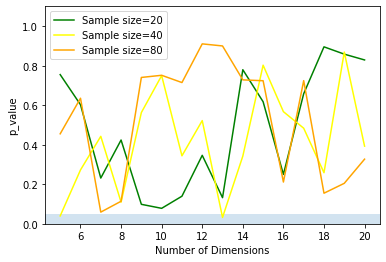

In [ ]:
plt.plot(num_dimensions[:16],m20_same,color='green',label='Sample size=20')
plt.plot(num_dimensions[:16],m40_same,color='yellow',label='Sample size=40')
plt.plot(num_dimensions[:16],m80_same,color='orange',label='Sample size=80')
plt.axhspan(0., 0.05, alpha=0.2)
plt.xlabel('Number of Dimensions')
plt.ylabel('p_value')
plt.ylim([0,1.1])
plt.legend(loc='upper left')

###Different mean (MMD)

Here shows where the two distributions are different. With a larger sample size, the test almost always draws the correct conclusion that the two distributions are different.

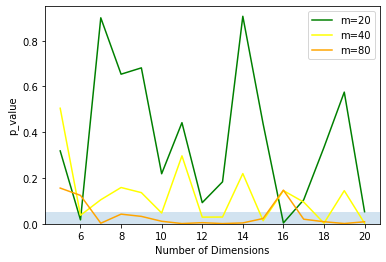

In [ ]:
plt.plot(num_dimensions[:16],m20_diff,color='green',label='m=20')
plt.plot(num_dimensions[:16],m40_diff,color='yellow',label='m=40')
plt.plot(num_dimensions[:16],m80_diff,color='orange',label='m=80')
plt.axhspan(0., 0.05, alpha=0.2)
plt.xlabel('Number of Dimensions')
plt.ylabel('p_value')
plt.ylim([0,.95])
plt.legend(loc='upper right')

In [15]:
rej_rate_KL_multi_diff=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/rejRateforKL_diffmean_multi_100.txt').transpose()
p_KL_multi_diff=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/pValueforKL_diffmean_multi_100.txt').transpose()
num_dimensions_KL=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/NumberofDimensions_KL.txt').transpose()
print(int(len(num_dimensions_KL)/3))


4


In [13]:
#define arrays
#m20_same=np.zeros(int(len(num_dimensions_KL)/3))
#m40_same=np.zeros(int(len(num_dimensions_KL)/3))
#m80_same=np.zeros(int(len(num_dimensions_KL)/3))

m20_diff_KL=np.zeros(int(len(num_dimensions_KL)/3))
m40_diff_KL=np.zeros(int(len(num_dimensions_KL)/3))
m80_diff_KL=np.zeros(int(len(num_dimensions_KL)/3))

m20_diff_rej_KL=np.zeros(int(len(num_dimensions_KL)/3))
m40_diff_rej_KL=np.zeros(int(len(num_dimensions_KL)/3))
m80_diff_rej_KL=np.zeros(int(len(num_dimensions_KL)/3))

#fill arrays with corresponding p_values
for i in range(int(len(num_dimensions_KL)/3)):
  #print(i)
  #print(i+int(len(num_dimensions)/3))
  #print(i+ 2*int(len(num_dimensions)/3))
  #m20_same[i]=p_MMD_multi_same[i]
  #m40_same[i]=p_MMD_multi_same[i+int(len(num_dimensions_KL)/3)]
  #m80_same[i]=p_MMD_multi_same[i+ 2*int(len(num_dimensions_KL)/3)]
  m20_diff_KL[i]=p_KL_multi_diff[i]
  m40_diff_KL[i]=p_KL_multi_diff[i+int(len(num_dimensions_KL)/3)]
  m80_diff_KL[i]=p_KL_multi_diff[i+ 2*int(len(num_dimensions_KL)/3)]
  m20_diff_rej_KL[i]=rej_rate_KL_multi_diff[i]
  m40_diff_rej_KL[i]=rej_rate_KL_multi_diff[i+int(len(num_dimensions_KL)/3)]
  m80_diff_rej_KL[i]=rej_rate_KL_multi_diff[i+ 2*int(len(num_dimensions_KL)/3)]


###Different mean (K-L)

This is to compare the results of the MMD test with the most popular multi-dimensionsal tests, the K-L test.

In [15]:
rej_rate_KL_multi_diff=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/rejRateforKL_diffmean_multi_100.txt').transpose()
p_KL_multi_diff=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/pValueforKL_diffmean_multi_correctAvg300.txt').transpose()
num_dimensions_KL=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/NumberofDimensions_KL.txt').transpose()
print(int(len(num_dimensions_KL)/3))
print(rej_rate_KL_multi_diff)
print(p_KL_multi_diff)

4
[0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.99 0.   0.99]
[0.73578 0.26921 0.00824 0.3738  0.70824 0.23183 0.38434 0.39359 0.49299
 0.12347 0.0029  0.08915]


In [16]:
#define arrays
#m20_same=np.zeros(int(len(num_dimensions_KL)/3))
#m40_same=np.zeros(int(len(num_dimensions_KL)/3))
#m80_same=np.zeros(int(len(num_dimensions_KL)/3))

m20_diff_KL=np.zeros(int(len(num_dimensions_KL)/3))
m40_diff_KL=np.zeros(int(len(num_dimensions_KL)/3))
m80_diff_KL=np.zeros(int(len(num_dimensions_KL)/3))

m20_diff_rej_KL=np.zeros(int(len(num_dimensions_KL)/3))
m40_diff_rej_KL=np.zeros(int(len(num_dimensions_KL)/3))
m80_diff_rej_KL=np.zeros(int(len(num_dimensions_KL)/3))

#fill arrays with corresponding p_values
for i in range(int(len(num_dimensions_KL)/3)):
  #print(i)
  #print(i+int(len(num_dimensions)/3))
  #print(i+ 2*int(len(num_dimensions)/3))
  #m20_same[i]=p_MMD_multi_same[i]
  #m40_same[i]=p_MMD_multi_same[i+int(len(num_dimensions_KL)/3)]
  #m80_same[i]=p_MMD_multi_same[i+ 2*int(len(num_dimensions_KL)/3)]
  m20_diff_KL[i]=p_KL_multi_diff[i]
  m40_diff_KL[i]=p_KL_multi_diff[i+int(len(num_dimensions_KL)/3)]
  m80_diff_KL[i]=p_KL_multi_diff[i+ 2*int(len(num_dimensions_KL)/3)]
  m20_diff_rej_KL[i]=rej_rate_KL_multi_diff[i]
  m40_diff_rej_KL[i]=rej_rate_KL_multi_diff[i+int(len(num_dimensions_KL)/3)]
  m80_diff_rej_KL[i]=rej_rate_KL_multi_diff[i+ 2*int(len(num_dimensions_KL)/3)]


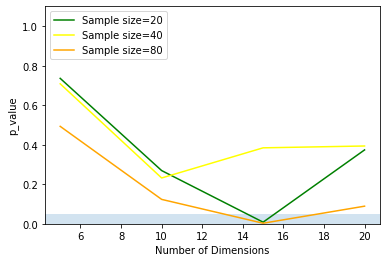

In [17]:
plt.plot(num_dimensions_KL[:4],m20_diff_KL,color='green',label='Sample size=20')
plt.plot(num_dimensions_KL[:4],m40_diff_KL,color='yellow',label='Sample size=40')
plt.plot(num_dimensions_KL[:4],m80_diff_KL,color='orange',label='Sample size=80')
plt.axhspan(0., 0.05, alpha=0.2)
plt.xlabel('Number of Dimensions')
plt.ylabel('p_value')
plt.ylim([0,1.1])
plt.legend(loc='upper left')

The K-L test is not accurate enough to reject the null hypothesis the majority of the time. This may be improved by increasing the number of iterations performed to calculate the average p_value.

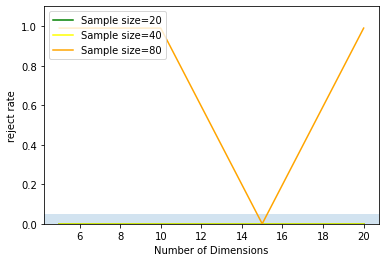

In [18]:
plt.plot(num_dimensions_KL[:4],m20_diff_rej_KL,color='green',label='Sample size=20')
plt.plot(num_dimensions_KL[:4],m40_diff_rej_KL,color='yellow',label='Sample size=40')
plt.plot(num_dimensions_KL[:4],m80_diff_rej_KL,color='orange',label='Sample size=80')
plt.axhspan(0., 0.05, alpha=0.2)
plt.xlabel('Number of Dimensions')
plt.ylabel('reject rate')
plt.ylim([0,1.1])
plt.legend(loc='upper left')

##Test varying the value of $\gamma$ on the average p_value

Here is an attempt to recreate the plot in the TATTER paper that studies the effect of changing $\gamma$ on the results of the MMD test. My plots were too noisy to make any general statements about the best value of $\gamma$. They were created using two gaussian distributions with different means ($\mu$ = 0.0 and 0.2)

In [ ]:
p_values_gamma=[]
sample_size_gamma=[]
#dimension=[]
gamma=np.linspace(1e-3,10,50)

m=np.array([40,80,120])
#dim=np.array([5,10,15,20])
for i in m:
  for j in gamma:
    mean_value1 = 0.
    mean_value2 =.2
  

    #mean_array1=np.zeros(j)
    #mean_array2=np.zeros(j)
    #cov=np.zeros((j,j))

    #for k in range(j):
      #mean_array1[k]=mean_value1
      #ean_array2[k]=mean_value2
      #cov[k,k]=1.

    X= normal(loc=mean_value1, scale=1.0, size=i)
    Y= normal(loc=mean_value2, scale=1.0, size=i)
    XX = X[:, np.newaxis]
    YY = Y[:, np.newaxis]
    

    l=1
    p_int=0.
    while l<10:
      #gamma=.1  

      mmd2u, mmd2u_null, p_value = two_sample_test(XX, YY,
                           model='MMD',
                           iterations=1000,
                           kernel_function='rbf',
                           gamma=j,
                           n_jobs=4)
    
      p_int+=p_value
      print(l)
      l+=1

    avg_p_value=p_int/10.
    reject_rate=rej/10.
    #dimension.append(j)
    p_values_gamma.append(avg_p_value)
    rej_rate_array.append(reject_rate)
  sample_size_gamma.append(i)
  

file3 = open("/content/gdrive/MyDrive/tatter-master/SampleSizeGamma.txt", "w")
np.savetxt(file3, np.array(sample_size_gamma))
file3.close()

file4 = open("/content/gdrive/MyDrive/tatter-master/pValueforMMD_diffmean_gamma.txt", "w")
np.savetxt(file4, np.array(p_values_gamma))
file4.close()

file5 = open("/content/gdrive/MyDrive/tatter-master/Gamma.txt", "w")
np.savetxt(file5, gamma)
file5.close()

1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5


In [5]:
sample_gamma=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/SampleSizeGamma.txt')
p_value_gamma=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/pValueforMMD_diffmean_gamma.txt')
gamma=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/Gamma.txt')

In [9]:
#define arrays
sample40=np.zeros(int(len(p_value_gamma)/3))
sample80=np.zeros(int(len(p_value_gamma)/3))
sample120=np.zeros(int(len(p_value_gamma)/3))


#fill arrays with corresponding p_values
for i in range(int(len(p_value_gamma)/3)):
  #print(i)
  #print(i+int(len(num_dimensions)/3))
  #print(i+ 2*int(len(num_dimensions)/3))
  sample40[i]=p_value_gamma[i]
  sample80[i]=p_value_gamma[i+int(len(p_value_gamma)/3)]
  sample120[i]=p_value_gamma[i+ 2*int(len(p_value_gamma)/3)]

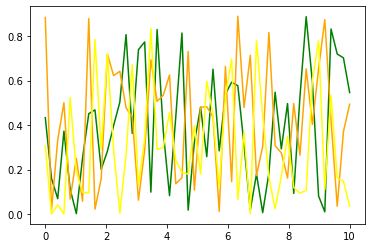

In [10]:
plt.plot(gamma,sample40,color='green',label='sample size = 40')
plt.plot(gamma,sample80,color='orange',label='sample size = 80')
plt.plot(gamma,sample120,color='yellow',label='sample size = 120')

##Comparing two different distributions

Finally I want to test to see if the MMD test can differentiate between two different distributions with the same mean and variance.

In [11]:
sample_size_array=[]
p_values_array=[]
rej_rate_array=[]

i=1
while i<12:
  i_int=i*100
  p_int=0.
  j=0
  rej=0
  while j<20:
    #print(p_int)
    X=normal(loc=0., scale=1.0, size=i_int)
    #print(X.shape[1])
    Y=lognormal(0., 1.0, size=i_int)
    #print(Y.shape)
    #gamma = 5.
    gamma=.1
    XX = X[:, np.newaxis]
    YY = Y[:, np.newaxis]

    sigma2 = np.median(pairwise_distances(XX, YY, metric='euclidean'))**2 * 2.0
    mmd2u, mmd2u_null, p_value = two_sample_test(XX, YY,
                           model='MMD',
                           iterations=1000,
                           kernel_function='rbf',
                           gamma=gamma,
                           n_jobs=1,
                           verbose=True)
    
    if p_value<.05:
      rej+=1
    p_int+=p_value
    print(j)
    j+=1
  
  avg_p_value=p_int/20.
  reject_rate=rej/20.
    
  rej_rate_array.append(reject_rate)
  sample_size_array.append(i_int)
  p_values_array.append(avg_p_value)
  #print(i)
  i=i+1

file1 = open("/content/gdrive/MyDrive/tatter-master/SampleSize_twoDiffDistTrue_new.txt", "w")
np.savetxt(file1, sample_size_array)
file1.close()

file2 = open("/content/gdrive/MyDrive/tatter-master/pValueforKLTest_twoDiffDist.txt", "w")
np.savetxt(file2, p_values_array)
file2.close()

file3 = open("/content/gdrive/MyDrive/tatter-master/rejRateMMD_twoDiffDist.txt", "w")
np.savetxt(file3, rej_rate_array)
file3.close()

#plt.plot(sample_size,p_values)

test value = 0.16571414815770025
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2668.08it/s]


p-value < 0.001 	 (resolution : 0.001)
0
test value = 0.225358052119631
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2658.68it/s]


p-value < 0.001 	 (resolution : 0.001)
1
test value = 0.22204978451601676
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2638.48it/s]


p-value < 0.001 	 (resolution : 0.001)
2
test value = 0.14686349154371903
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2647.19it/s]


p-value < 0.001 	 (resolution : 0.001)
3
test value = 0.07677164444637019
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2654.00it/s]


p-value < 0.001 	 (resolution : 0.001)
4
test value = 0.23387834789487516
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2593.42it/s]


p-value < 0.001 	 (resolution : 0.001)
5
test value = 0.17558842635808047
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2788.44it/s]


p-value < 0.001 	 (resolution : 0.001)
6
test value = 0.19828652698855675
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2632.29it/s]


p-value < 0.001 	 (resolution : 0.001)
7
test value = 0.22000660505472602
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2722.08it/s]


p-value < 0.001 	 (resolution : 0.001)
8
test value = 0.15481500564077422
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2662.93it/s]


p-value < 0.001 	 (resolution : 0.001)
9
test value = 0.16937754676311578
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2549.02it/s]


p-value < 0.001 	 (resolution : 0.001)
10
test value = 0.1273627864224427
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2611.01it/s]


p-value < 0.001 	 (resolution : 0.001)
11
test value = 0.16583801696289746
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2610.49it/s]


p-value < 0.001 	 (resolution : 0.001)
12
test value = 0.22291150012573047
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2647.73it/s]


p-value < 0.001 	 (resolution : 0.001)
13
test value = 0.1661263228277503
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2706.18it/s]


p-value < 0.001 	 (resolution : 0.001)
14
test value = 0.12004701711199006
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2542.90it/s]


p-value < 0.001 	 (resolution : 0.001)
15
test value = 0.13287328838867496
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2717.06it/s]


p-value < 0.001 	 (resolution : 0.001)
16
test value = 0.15915127472034718
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2725.09it/s]


p-value < 0.001 	 (resolution : 0.001)
17
test value = 0.19329815990301236
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2669.04it/s]


p-value < 0.001 	 (resolution : 0.001)
18
test value = 0.17580782078406343
Computing the null distribution.


100%|██████████| 1000/1000 [00:00<00:00, 2737.58it/s]


p-value < 0.001 	 (resolution : 0.001)
19
test value = 0.18030789242902867
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 578.52it/s]


p-value < 0.001 	 (resolution : 0.001)
0
test value = 0.15792044023490126
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 586.06it/s]


p-value < 0.001 	 (resolution : 0.001)
1
test value = 0.1742357987361367
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 586.40it/s]


p-value < 0.001 	 (resolution : 0.001)
2
test value = 0.14017568177390483
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 554.76it/s]


p-value < 0.001 	 (resolution : 0.001)
3
test value = 0.1739650807362283
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 599.92it/s]


p-value < 0.001 	 (resolution : 0.001)
4
test value = 0.11574693886024523
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 582.33it/s]


p-value < 0.001 	 (resolution : 0.001)
5
test value = 0.1678507539387255
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 591.76it/s]


p-value < 0.001 	 (resolution : 0.001)
6
test value = 0.1413380941616924
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 602.35it/s]


p-value < 0.001 	 (resolution : 0.001)
7
test value = 0.11219752039705222
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 616.22it/s]


p-value < 0.001 	 (resolution : 0.001)
8
test value = 0.14713224537786984
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 601.90it/s]


p-value < 0.001 	 (resolution : 0.001)
9
test value = 0.15087839214967236
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 590.10it/s]


p-value < 0.001 	 (resolution : 0.001)
10
test value = 0.1331253980529452
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 568.36it/s]


p-value < 0.001 	 (resolution : 0.001)
11
test value = 0.16316399288641126
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 559.17it/s]


p-value < 0.001 	 (resolution : 0.001)
12
test value = 0.14161712724028708
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 592.98it/s]


p-value < 0.001 	 (resolution : 0.001)
13
test value = 0.15916764922898552
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 586.93it/s]


p-value < 0.001 	 (resolution : 0.001)
14
test value = 0.13231000589233055
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 593.76it/s]


p-value < 0.001 	 (resolution : 0.001)
15
test value = 0.17515437350466145
Computing the null distribution.


100%|██████████| 1000/1000 [00:01<00:00, 602.91it/s]


p-value < 0.001 	 (resolution : 0.001)
16
test value = 0.16116823589623563
Computing the null distribution.


100%|██████████| 1000/1000 [00:02<00:00, 364.21it/s]


p-value < 0.001 	 (resolution : 0.001)
17
test value = 0.17209360009686425
Computing the null distribution.


100%|██████████| 1000/1000 [00:04<00:00, 231.60it/s]


p-value < 0.001 	 (resolution : 0.001)
18
test value = 0.1862675371590803
Computing the null distribution.


100%|██████████| 1000/1000 [00:02<00:00, 406.83it/s]


p-value < 0.001 	 (resolution : 0.001)
19
test value = 0.19258947618796274
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 178.85it/s]


p-value < 0.001 	 (resolution : 0.001)
0
test value = 0.14776753199863624
Computing the null distribution.


100%|██████████| 1000/1000 [00:07<00:00, 142.56it/s]


p-value < 0.001 	 (resolution : 0.001)
1
test value = 0.16649261541217197
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 176.12it/s]


p-value < 0.001 	 (resolution : 0.001)
2
test value = 0.14732672080402476
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 177.38it/s]


p-value < 0.001 	 (resolution : 0.001)
3
test value = 0.12922842256391953
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 175.80it/s]


p-value < 0.001 	 (resolution : 0.001)
4
test value = 0.14291553743464758
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 177.29it/s]


p-value < 0.001 	 (resolution : 0.001)
5
test value = 0.18731352861731598
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 180.55it/s]


p-value < 0.001 	 (resolution : 0.001)
6
test value = 0.20067994172762726
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 179.43it/s]


p-value < 0.001 	 (resolution : 0.001)
7
test value = 0.15079709027400945
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 182.17it/s]


p-value < 0.001 	 (resolution : 0.001)
8
test value = 0.19532146267049422
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 180.52it/s]


p-value < 0.001 	 (resolution : 0.001)
9
test value = 0.16037848214093553
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 183.94it/s]


p-value < 0.001 	 (resolution : 0.001)
10
test value = 0.16830423107944736
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 183.17it/s]


p-value < 0.001 	 (resolution : 0.001)
11
test value = 0.1605433413945525
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 183.07it/s]


p-value < 0.001 	 (resolution : 0.001)
12
test value = 0.1772562320633997
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 183.83it/s]


p-value < 0.001 	 (resolution : 0.001)
13
test value = 0.17372662975732434
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 181.85it/s]


p-value < 0.001 	 (resolution : 0.001)
14
test value = 0.15666468213745355
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 183.81it/s]


p-value < 0.001 	 (resolution : 0.001)
15
test value = 0.17735188303869043
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 183.66it/s]


p-value < 0.001 	 (resolution : 0.001)
16
test value = 0.17432248220663094
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 181.34it/s]


p-value < 0.001 	 (resolution : 0.001)
17
test value = 0.16538127323649654
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 180.76it/s]


p-value < 0.001 	 (resolution : 0.001)
18
test value = 0.13340847643302567
Computing the null distribution.


100%|██████████| 1000/1000 [00:05<00:00, 180.20it/s]


p-value < 0.001 	 (resolution : 0.001)
19
test value = 0.17385452073128937
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 85.98it/s]


p-value < 0.001 	 (resolution : 0.001)
0
test value = 0.15576606734112608
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 84.88it/s]


p-value < 0.001 	 (resolution : 0.001)
1
test value = 0.14197181437958473
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 83.41it/s]


p-value < 0.001 	 (resolution : 0.001)
2
test value = 0.16151303311479226
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 87.64it/s]


p-value < 0.001 	 (resolution : 0.001)
3
test value = 0.16098789367989674
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 87.09it/s]


p-value < 0.001 	 (resolution : 0.001)
4
test value = 0.1248594117103099
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 90.04it/s]


p-value < 0.001 	 (resolution : 0.001)
5
test value = 0.1270449415138395
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 89.89it/s]


p-value < 0.001 	 (resolution : 0.001)
6
test value = 0.13946295466500414
Computing the null distribution.


100%|██████████| 1000/1000 [00:10<00:00, 92.67it/s]


p-value < 0.001 	 (resolution : 0.001)
7
test value = 0.1527303427405562
Computing the null distribution.


100%|██████████| 1000/1000 [00:10<00:00, 90.92it/s]


p-value < 0.001 	 (resolution : 0.001)
8
test value = 0.15867925225936053
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 89.61it/s]


p-value < 0.001 	 (resolution : 0.001)
9
test value = 0.14592147128098354
Computing the null distribution.


100%|██████████| 1000/1000 [00:10<00:00, 91.14it/s]


p-value < 0.001 	 (resolution : 0.001)
10
test value = 0.14791848482430714
Computing the null distribution.


100%|██████████| 1000/1000 [00:10<00:00, 91.02it/s]


p-value < 0.001 	 (resolution : 0.001)
11
test value = 0.18353994908681126
Computing the null distribution.


100%|██████████| 1000/1000 [00:10<00:00, 91.92it/s]


p-value < 0.001 	 (resolution : 0.001)
12
test value = 0.15228721863318628
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 84.33it/s]


p-value < 0.001 	 (resolution : 0.001)
13
test value = 0.1515776619355338
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 88.61it/s]


p-value < 0.001 	 (resolution : 0.001)
14
test value = 0.15834340054713913
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 88.73it/s]


p-value < 0.001 	 (resolution : 0.001)
15
test value = 0.13594660885122933
Computing the null distribution.


100%|██████████| 1000/1000 [00:10<00:00, 92.24it/s]


p-value < 0.001 	 (resolution : 0.001)
16
test value = 0.15700268023652741
Computing the null distribution.


100%|██████████| 1000/1000 [00:14<00:00, 66.83it/s]


p-value < 0.001 	 (resolution : 0.001)
17
test value = 0.17046842628601988
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 87.97it/s]


p-value < 0.001 	 (resolution : 0.001)
18
test value = 0.168964094634261
Computing the null distribution.


100%|██████████| 1000/1000 [00:11<00:00, 89.11it/s]


p-value < 0.001 	 (resolution : 0.001)
19
test value = 0.1401475467375839
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 48.06it/s]


p-value < 0.001 	 (resolution : 0.001)
0
test value = 0.1621400263929993
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 48.96it/s]


p-value < 0.001 	 (resolution : 0.001)
1
test value = 0.18068593646887154
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 48.61it/s]


p-value < 0.001 	 (resolution : 0.001)
2
test value = 0.14213151953877934
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 49.41it/s]


p-value < 0.001 	 (resolution : 0.001)
3
test value = 0.1597536127287591
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 49.60it/s]


p-value < 0.001 	 (resolution : 0.001)
4
test value = 0.1618847198169715
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 47.84it/s]


p-value < 0.001 	 (resolution : 0.001)
5
test value = 0.14644290991838926
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 49.29it/s]


p-value < 0.001 	 (resolution : 0.001)
6
test value = 0.15288146795558744
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 47.92it/s]


p-value < 0.001 	 (resolution : 0.001)
7
test value = 0.1645249242130613
Computing the null distribution.


100%|██████████| 1000/1000 [00:21<00:00, 46.34it/s]


p-value < 0.001 	 (resolution : 0.001)
8
test value = 0.15682875591259227
Computing the null distribution.


100%|██████████| 1000/1000 [00:21<00:00, 47.43it/s]


p-value < 0.001 	 (resolution : 0.001)
9
test value = 0.12828245292994933
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 47.72it/s]


p-value < 0.001 	 (resolution : 0.001)
10
test value = 0.15291884179404702
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 48.47it/s]


p-value < 0.001 	 (resolution : 0.001)
11
test value = 0.14453074101138474
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 48.80it/s]


p-value < 0.001 	 (resolution : 0.001)
12
test value = 0.15412744027720704
Computing the null distribution.


100%|██████████| 1000/1000 [00:24<00:00, 40.91it/s]


p-value < 0.001 	 (resolution : 0.001)
13
test value = 0.16248703235377615
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 47.73it/s]


p-value < 0.001 	 (resolution : 0.001)
14
test value = 0.191509966725399
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 48.99it/s]


p-value < 0.001 	 (resolution : 0.001)
15
test value = 0.14534930786728228
Computing the null distribution.


100%|██████████| 1000/1000 [00:19<00:00, 50.85it/s]


p-value < 0.001 	 (resolution : 0.001)
16
test value = 0.16424093261397688
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 48.80it/s]


p-value < 0.001 	 (resolution : 0.001)
17
test value = 0.17738208000655864
Computing the null distribution.


100%|██████████| 1000/1000 [00:20<00:00, 49.38it/s]


p-value < 0.001 	 (resolution : 0.001)
18
test value = 0.15283786478002215
Computing the null distribution.


100%|██████████| 1000/1000 [00:19<00:00, 50.62it/s]


p-value < 0.001 	 (resolution : 0.001)
19
test value = 0.15333482126465547
Computing the null distribution.


100%|██████████| 1000/1000 [00:33<00:00, 30.07it/s]


p-value < 0.001 	 (resolution : 0.001)
0
test value = 0.15714633830854718
Computing the null distribution.


100%|██████████| 1000/1000 [00:33<00:00, 30.30it/s]


p-value < 0.001 	 (resolution : 0.001)
1
test value = 0.16520864812534786
Computing the null distribution.


100%|██████████| 1000/1000 [00:32<00:00, 30.64it/s]


p-value < 0.001 	 (resolution : 0.001)
2
test value = 0.16915959185680496
Computing the null distribution.


100%|██████████| 1000/1000 [00:33<00:00, 30.26it/s]


p-value < 0.001 	 (resolution : 0.001)
3
test value = 0.1777232421535948
Computing the null distribution.


100%|██████████| 1000/1000 [00:32<00:00, 30.53it/s]


p-value < 0.001 	 (resolution : 0.001)
4
test value = 0.18666700497300726
Computing the null distribution.


100%|██████████| 1000/1000 [00:36<00:00, 27.33it/s]


p-value < 0.001 	 (resolution : 0.001)
5
test value = 0.1642495621831217
Computing the null distribution.


100%|██████████| 1000/1000 [00:32<00:00, 30.31it/s]


p-value < 0.001 	 (resolution : 0.001)
6
test value = 0.1571656272783195
Computing the null distribution.


100%|██████████| 1000/1000 [00:33<00:00, 29.86it/s]


p-value < 0.001 	 (resolution : 0.001)
7
test value = 0.16553464233446324
Computing the null distribution.


100%|██████████| 1000/1000 [00:32<00:00, 30.47it/s]


p-value < 0.001 	 (resolution : 0.001)
8
test value = 0.17406309120010643
Computing the null distribution.


100%|██████████| 1000/1000 [00:33<00:00, 30.07it/s]


p-value < 0.001 	 (resolution : 0.001)
9
test value = 0.1530456179429538
Computing the null distribution.


100%|██████████| 1000/1000 [00:32<00:00, 30.56it/s]


p-value < 0.001 	 (resolution : 0.001)
10
test value = 0.16346892481040487
Computing the null distribution.


100%|██████████| 1000/1000 [00:31<00:00, 31.27it/s]


p-value < 0.001 	 (resolution : 0.001)
11
test value = 0.18852181069918528
Computing the null distribution.


100%|██████████| 1000/1000 [00:32<00:00, 30.93it/s]


p-value < 0.001 	 (resolution : 0.001)
12
test value = 0.1784748306623316
Computing the null distribution.


100%|██████████| 1000/1000 [00:31<00:00, 32.07it/s]


p-value < 0.001 	 (resolution : 0.001)
13
test value = 0.1553943812817582
Computing the null distribution.


100%|██████████| 1000/1000 [00:34<00:00, 28.74it/s]


p-value < 0.001 	 (resolution : 0.001)
14
test value = 0.184558395268694
Computing the null distribution.


100%|██████████| 1000/1000 [00:30<00:00, 32.52it/s]


p-value < 0.001 	 (resolution : 0.001)
15
test value = 0.1562151369767042
Computing the null distribution.


100%|██████████| 1000/1000 [00:31<00:00, 32.16it/s]


p-value < 0.001 	 (resolution : 0.001)
16
test value = 0.1558850065036974
Computing the null distribution.


100%|██████████| 1000/1000 [00:31<00:00, 31.87it/s]


p-value < 0.001 	 (resolution : 0.001)
17
test value = 0.14233135119903118
Computing the null distribution.


100%|██████████| 1000/1000 [00:31<00:00, 32.18it/s]


p-value < 0.001 	 (resolution : 0.001)
18
test value = 0.1424159865915675
Computing the null distribution.


100%|██████████| 1000/1000 [00:31<00:00, 32.09it/s]


p-value < 0.001 	 (resolution : 0.001)
19
test value = 0.15125490580026768
Computing the null distribution.


100%|██████████| 1000/1000 [00:47<00:00, 20.92it/s]


p-value < 0.001 	 (resolution : 0.001)
0
test value = 0.16672824733474356
Computing the null distribution.


100%|██████████| 1000/1000 [00:47<00:00, 20.92it/s]


p-value < 0.001 	 (resolution : 0.001)
1
test value = 0.15133978749546606
Computing the null distribution.


100%|██████████| 1000/1000 [00:51<00:00, 19.56it/s]


p-value < 0.001 	 (resolution : 0.001)
2
test value = 0.1757015170109395
Computing the null distribution.


100%|██████████| 1000/1000 [00:47<00:00, 21.01it/s]


p-value < 0.001 	 (resolution : 0.001)
3
test value = 0.18031879175776266
Computing the null distribution.


100%|██████████| 1000/1000 [00:47<00:00, 21.10it/s]


p-value < 0.001 	 (resolution : 0.001)
4
test value = 0.16082327154037523
Computing the null distribution.


100%|██████████| 1000/1000 [00:47<00:00, 21.24it/s]


p-value < 0.001 	 (resolution : 0.001)
5
test value = 0.17735421305030896
Computing the null distribution.


100%|██████████| 1000/1000 [00:47<00:00, 21.24it/s]


p-value < 0.001 	 (resolution : 0.001)
6
test value = 0.18052919876525464
Computing the null distribution.


100%|██████████| 1000/1000 [00:46<00:00, 21.40it/s]


p-value < 0.001 	 (resolution : 0.001)
7
test value = 0.17462499761076145
Computing the null distribution.


100%|██████████| 1000/1000 [00:47<00:00, 20.97it/s]


p-value < 0.001 	 (resolution : 0.001)
8
test value = 0.16881904600635078
Computing the null distribution.


100%|██████████| 1000/1000 [00:51<00:00, 19.50it/s]


p-value < 0.001 	 (resolution : 0.001)
9
test value = 0.15625572766781626
Computing the null distribution.


100%|██████████| 1000/1000 [00:47<00:00, 21.04it/s]


p-value < 0.001 	 (resolution : 0.001)
10
test value = 0.1711079171804306
Computing the null distribution.


100%|██████████| 1000/1000 [00:47<00:00, 21.19it/s]


p-value < 0.001 	 (resolution : 0.001)
11
test value = 0.16132885549167097
Computing the null distribution.


100%|██████████| 1000/1000 [00:47<00:00, 21.09it/s]


p-value < 0.001 	 (resolution : 0.001)
12
test value = 0.1507139715470076
Computing the null distribution.


100%|██████████| 1000/1000 [00:47<00:00, 20.90it/s]


p-value < 0.001 	 (resolution : 0.001)
13
test value = 0.1323049511718244
Computing the null distribution.


100%|██████████| 1000/1000 [00:47<00:00, 21.08it/s]


p-value < 0.001 	 (resolution : 0.001)
14
test value = 0.15914441131324808
Computing the null distribution.


100%|██████████| 1000/1000 [00:50<00:00, 19.93it/s]


p-value < 0.001 	 (resolution : 0.001)
15
test value = 0.16650271443598297
Computing the null distribution.


100%|██████████| 1000/1000 [00:46<00:00, 21.30it/s]


p-value < 0.001 	 (resolution : 0.001)
16
test value = 0.16523377113272852
Computing the null distribution.


100%|██████████| 1000/1000 [00:46<00:00, 21.29it/s]


p-value < 0.001 	 (resolution : 0.001)
17
test value = 0.16528799217382573
Computing the null distribution.


100%|██████████| 1000/1000 [00:47<00:00, 21.07it/s]


p-value < 0.001 	 (resolution : 0.001)
18
test value = 0.1529745789729544
Computing the null distribution.


100%|██████████| 1000/1000 [00:49<00:00, 20.09it/s]


p-value < 0.001 	 (resolution : 0.001)
19
test value = 0.18198069609484024
Computing the null distribution.


100%|██████████| 1000/1000 [01:04<00:00, 15.62it/s]


p-value < 0.001 	 (resolution : 0.001)
0
test value = 0.16621733721609533
Computing the null distribution.


100%|██████████| 1000/1000 [01:06<00:00, 14.95it/s]


p-value < 0.001 	 (resolution : 0.001)
1
test value = 0.16191890306200096
Computing the null distribution.


100%|██████████| 1000/1000 [01:03<00:00, 15.80it/s]


p-value < 0.001 	 (resolution : 0.001)
2
test value = 0.17891345212990073
Computing the null distribution.


100%|██████████| 1000/1000 [01:03<00:00, 15.87it/s]


p-value < 0.001 	 (resolution : 0.001)
3
test value = 0.16418261559399805
Computing the null distribution.


100%|██████████| 1000/1000 [01:02<00:00, 15.92it/s]


p-value < 0.001 	 (resolution : 0.001)
4
test value = 0.1602720457047102
Computing the null distribution.


100%|██████████| 1000/1000 [01:03<00:00, 15.65it/s]


p-value < 0.001 	 (resolution : 0.001)
5
test value = 0.15407022055244446
Computing the null distribution.


100%|██████████| 1000/1000 [01:06<00:00, 15.00it/s]


p-value < 0.001 	 (resolution : 0.001)
6
test value = 0.14750723771498664
Computing the null distribution.


100%|██████████| 1000/1000 [01:03<00:00, 15.81it/s]


p-value < 0.001 	 (resolution : 0.001)
7
test value = 0.15431307703290797
Computing the null distribution.


100%|██████████| 1000/1000 [01:03<00:00, 15.81it/s]


p-value < 0.001 	 (resolution : 0.001)
8
test value = 0.1617620976996068
Computing the null distribution.


100%|██████████| 1000/1000 [01:03<00:00, 15.85it/s]


p-value < 0.001 	 (resolution : 0.001)
9
test value = 0.1810143986328434
Computing the null distribution.


100%|██████████| 1000/1000 [01:06<00:00, 15.13it/s]


p-value < 0.001 	 (resolution : 0.001)
10
test value = 0.16233349744591097
Computing the null distribution.


100%|██████████| 1000/1000 [01:02<00:00, 16.02it/s]


p-value < 0.001 	 (resolution : 0.001)
11
test value = 0.17164428347376193
Computing the null distribution.


100%|██████████| 1000/1000 [01:02<00:00, 16.03it/s]


p-value < 0.001 	 (resolution : 0.001)
12
test value = 0.13002964100409398
Computing the null distribution.


100%|██████████| 1000/1000 [01:02<00:00, 16.03it/s]


p-value < 0.001 	 (resolution : 0.001)
13
test value = 0.15118224308677863
Computing the null distribution.


100%|██████████| 1000/1000 [01:02<00:00, 15.91it/s]


p-value < 0.001 	 (resolution : 0.001)
14
test value = 0.16885622403590572
Computing the null distribution.


100%|██████████| 1000/1000 [01:06<00:00, 15.05it/s]


p-value < 0.001 	 (resolution : 0.001)
15
test value = 0.17278229082379482
Computing the null distribution.


100%|██████████| 1000/1000 [01:03<00:00, 15.86it/s]


p-value < 0.001 	 (resolution : 0.001)
16
test value = 0.1752297406110761
Computing the null distribution.


100%|██████████| 1000/1000 [01:02<00:00, 15.88it/s]


p-value < 0.001 	 (resolution : 0.001)
17
test value = 0.16108393099948537
Computing the null distribution.


100%|██████████| 1000/1000 [01:03<00:00, 15.72it/s]


p-value < 0.001 	 (resolution : 0.001)
18
test value = 0.15398865094890146
Computing the null distribution.


100%|██████████| 1000/1000 [01:03<00:00, 15.64it/s]


p-value < 0.001 	 (resolution : 0.001)
19
test value = 0.17089327472316795
Computing the null distribution.


100%|██████████| 1000/1000 [01:26<00:00, 11.52it/s]


p-value < 0.001 	 (resolution : 0.001)
0
test value = 0.1477650020577157
Computing the null distribution.


100%|██████████| 1000/1000 [01:23<00:00, 12.02it/s]


p-value < 0.001 	 (resolution : 0.001)
1
test value = 0.1561395045215508
Computing the null distribution.


100%|██████████| 1000/1000 [01:22<00:00, 12.17it/s]


p-value < 0.001 	 (resolution : 0.001)
2
test value = 0.1487641887129334
Computing the null distribution.


100%|██████████| 1000/1000 [01:25<00:00, 11.73it/s]


p-value < 0.001 	 (resolution : 0.001)
3
test value = 0.1487770762427314
Computing the null distribution.


100%|██████████| 1000/1000 [01:21<00:00, 12.28it/s]


p-value < 0.001 	 (resolution : 0.001)
4
test value = 0.16992337442320693
Computing the null distribution.


100%|██████████| 1000/1000 [01:21<00:00, 12.23it/s]


p-value < 0.001 	 (resolution : 0.001)
5
test value = 0.15670525756710685
Computing the null distribution.


100%|██████████| 1000/1000 [01:22<00:00, 12.19it/s]


p-value < 0.001 	 (resolution : 0.001)
6
test value = 0.14337371172503044
Computing the null distribution.


100%|██████████| 1000/1000 [01:25<00:00, 11.65it/s]


p-value < 0.001 	 (resolution : 0.001)
7
test value = 0.15369029121523514
Computing the null distribution.


100%|██████████| 1000/1000 [01:22<00:00, 12.18it/s]


p-value < 0.001 	 (resolution : 0.001)
8
test value = 0.1556573367526899
Computing the null distribution.


100%|██████████| 1000/1000 [01:22<00:00, 12.13it/s]


p-value < 0.001 	 (resolution : 0.001)
9
test value = 0.15156938909183437
Computing the null distribution.


100%|██████████| 1000/1000 [01:25<00:00, 11.67it/s]


p-value < 0.001 	 (resolution : 0.001)
10
test value = 0.1577317577424604
Computing the null distribution.


100%|██████████| 1000/1000 [01:23<00:00, 11.95it/s]


p-value < 0.001 	 (resolution : 0.001)
11
test value = 0.1552144569952103
Computing the null distribution.


100%|██████████| 1000/1000 [01:22<00:00, 12.14it/s]


p-value < 0.001 	 (resolution : 0.001)
12
test value = 0.14814039793411116
Computing the null distribution.


100%|██████████| 1000/1000 [01:22<00:00, 12.18it/s]


p-value < 0.001 	 (resolution : 0.001)
13
test value = 0.1755292836928315
Computing the null distribution.


100%|██████████| 1000/1000 [01:25<00:00, 11.70it/s]


p-value < 0.001 	 (resolution : 0.001)
14
test value = 0.16899160976127225
Computing the null distribution.


100%|██████████| 1000/1000 [01:22<00:00, 12.12it/s]


p-value < 0.001 	 (resolution : 0.001)
15
test value = 0.17083263889469813
Computing the null distribution.


100%|██████████| 1000/1000 [01:22<00:00, 12.07it/s]


p-value < 0.001 	 (resolution : 0.001)
16
test value = 0.17124121773489032
Computing the null distribution.


100%|██████████| 1000/1000 [01:25<00:00, 11.64it/s]


p-value < 0.001 	 (resolution : 0.001)
17
test value = 0.16887072971432682
Computing the null distribution.


100%|██████████| 1000/1000 [01:22<00:00, 12.17it/s]


p-value < 0.001 	 (resolution : 0.001)
18
test value = 0.15624858843500267
Computing the null distribution.


100%|██████████| 1000/1000 [01:22<00:00, 12.13it/s]


p-value < 0.001 	 (resolution : 0.001)
19
test value = 0.15555903189410114
Computing the null distribution.


100%|██████████| 1000/1000 [01:49<00:00,  9.16it/s]


p-value < 0.001 	 (resolution : 0.001)
0
test value = 0.17799163988861566
Computing the null distribution.


100%|██████████| 1000/1000 [01:44<00:00,  9.52it/s]


p-value < 0.001 	 (resolution : 0.001)
1
test value = 0.15182730299443392
Computing the null distribution.


100%|██████████| 1000/1000 [01:46<00:00,  9.42it/s]


p-value < 0.001 	 (resolution : 0.001)
2
test value = 0.16886913338143672
Computing the null distribution.


100%|██████████| 1000/1000 [01:48<00:00,  9.24it/s]


p-value < 0.001 	 (resolution : 0.001)
3
test value = 0.1675944554917257
Computing the null distribution.


100%|██████████| 1000/1000 [01:44<00:00,  9.56it/s]


p-value < 0.001 	 (resolution : 0.001)
4
test value = 0.1557295366425382
Computing the null distribution.


100%|██████████| 1000/1000 [01:45<00:00,  9.48it/s]


p-value < 0.001 	 (resolution : 0.001)
5
test value = 0.15462745172851222
Computing the null distribution.


100%|██████████| 1000/1000 [01:48<00:00,  9.24it/s]


p-value < 0.001 	 (resolution : 0.001)
6
test value = 0.1578061139540019
Computing the null distribution.


100%|██████████| 1000/1000 [01:45<00:00,  9.49it/s]


p-value < 0.001 	 (resolution : 0.001)
7
test value = 0.170285471287982
Computing the null distribution.


100%|██████████| 1000/1000 [01:48<00:00,  9.24it/s]


p-value < 0.001 	 (resolution : 0.001)
8
test value = 0.14166229534253638
Computing the null distribution.


100%|██████████| 1000/1000 [01:45<00:00,  9.52it/s]


p-value < 0.001 	 (resolution : 0.001)
9
test value = 0.1510828668304789
Computing the null distribution.


100%|██████████| 1000/1000 [01:46<00:00,  9.38it/s]


p-value < 0.001 	 (resolution : 0.001)
10
test value = 0.15313964777158962
Computing the null distribution.


100%|██████████| 1000/1000 [01:52<00:00,  8.93it/s]


p-value < 0.001 	 (resolution : 0.001)
11
test value = 0.17000604164313504
Computing the null distribution.


100%|██████████| 1000/1000 [01:48<00:00,  9.24it/s]


p-value < 0.001 	 (resolution : 0.001)
12
test value = 0.16601062357229446
Computing the null distribution.


100%|██████████| 1000/1000 [01:47<00:00,  9.28it/s]


p-value < 0.001 	 (resolution : 0.001)
13
test value = 0.15129127675873089
Computing the null distribution.


100%|██████████| 1000/1000 [01:45<00:00,  9.52it/s]


p-value < 0.001 	 (resolution : 0.001)
14
test value = 0.15859070549158294
Computing the null distribution.


100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s]


p-value < 0.001 	 (resolution : 0.001)
15
test value = 0.16173367638816605
Computing the null distribution.


100%|██████████| 1000/1000 [01:48<00:00,  9.23it/s]


p-value < 0.001 	 (resolution : 0.001)
16
test value = 0.1623818102241772
Computing the null distribution.


100%|██████████| 1000/1000 [01:45<00:00,  9.52it/s]


p-value < 0.001 	 (resolution : 0.001)
17
test value = 0.18644763199843228
Computing the null distribution.


100%|██████████| 1000/1000 [01:47<00:00,  9.27it/s]


p-value < 0.001 	 (resolution : 0.001)
18
test value = 0.14715988879416853
Computing the null distribution.


100%|██████████| 1000/1000 [01:45<00:00,  9.52it/s]


p-value < 0.001 	 (resolution : 0.001)
19
test value = 0.1455106971093172
Computing the null distribution.


100%|██████████| 1000/1000 [02:19<00:00,  7.17it/s]


p-value < 0.001 	 (resolution : 0.001)
0
test value = 0.17142858724793153
Computing the null distribution.


100%|██████████| 1000/1000 [02:48<00:00,  5.93it/s]


p-value < 0.001 	 (resolution : 0.001)
1
test value = 0.13334977195392073
Computing the null distribution.


100%|██████████| 1000/1000 [02:52<00:00,  5.80it/s]


p-value < 0.001 	 (resolution : 0.001)
2
test value = 0.1493201044172312
Computing the null distribution.


100%|██████████| 1000/1000 [02:47<00:00,  5.95it/s]


p-value < 0.001 	 (resolution : 0.001)
3
test value = 0.16103513634032596
Computing the null distribution.


100%|██████████| 1000/1000 [02:51<00:00,  5.85it/s]


p-value < 0.001 	 (resolution : 0.001)
4
test value = 0.16807222227964624
Computing the null distribution.


100%|██████████| 1000/1000 [02:52<00:00,  5.80it/s]


p-value < 0.001 	 (resolution : 0.001)
5
test value = 0.13253132372461907
Computing the null distribution.


100%|██████████| 1000/1000 [02:48<00:00,  5.92it/s]


p-value < 0.001 	 (resolution : 0.001)
6
test value = 0.1780065265944295
Computing the null distribution.


100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


p-value < 0.001 	 (resolution : 0.001)
7
test value = 0.17074711479529991
Computing the null distribution.


100%|██████████| 1000/1000 [02:51<00:00,  5.83it/s]


p-value < 0.001 	 (resolution : 0.001)
8
test value = 0.1726842723369546
Computing the null distribution.


100%|██████████| 1000/1000 [02:48<00:00,  5.94it/s]


p-value < 0.001 	 (resolution : 0.001)
9
test value = 0.19310116292625157
Computing the null distribution.


100%|██████████| 1000/1000 [02:51<00:00,  5.83it/s]


p-value < 0.001 	 (resolution : 0.001)
10
test value = 0.16935637271156057
Computing the null distribution.


100%|██████████| 1000/1000 [02:51<00:00,  5.84it/s]


p-value < 0.001 	 (resolution : 0.001)
11
test value = 0.17543635842518235
Computing the null distribution.


100%|██████████| 1000/1000 [02:48<00:00,  5.94it/s]


p-value < 0.001 	 (resolution : 0.001)
12
test value = 0.18763665449604572
Computing the null distribution.


100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


p-value < 0.001 	 (resolution : 0.001)
13
test value = 0.17903324831512712
Computing the null distribution.


100%|██████████| 1000/1000 [02:50<00:00,  5.86it/s]


p-value < 0.001 	 (resolution : 0.001)
14
test value = 0.1481799344495507
Computing the null distribution.


100%|██████████| 1000/1000 [02:48<00:00,  5.94it/s]


p-value < 0.001 	 (resolution : 0.001)
15
test value = 0.17337291539336652
Computing the null distribution.


100%|██████████| 1000/1000 [02:50<00:00,  5.85it/s]


p-value < 0.001 	 (resolution : 0.001)
16
test value = 0.1499930717125495
Computing the null distribution.


100%|██████████| 1000/1000 [02:50<00:00,  5.85it/s]


p-value < 0.001 	 (resolution : 0.001)
17
test value = 0.17253223086807434
Computing the null distribution.


100%|██████████| 1000/1000 [02:48<00:00,  5.94it/s]


p-value < 0.001 	 (resolution : 0.001)
18
test value = 0.1871117310346353
Computing the null distribution.


100%|██████████| 1000/1000 [02:52<00:00,  5.79it/s]


p-value < 0.001 	 (resolution : 0.001)
19


In [4]:
sample_diffDist=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/SampleSize_twoDiffDist.txt')
sample_diffDist_KL=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/SampleSize_twoDiffDistTrue_new.txt')
p_value_MMD_diffDist=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/pValueforMMDTest_twoDiffDist.txt')
p_value_KS_diffDist=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/pValueforKSTest_twoDiffDist.txt')
p_value_KL_diffDist=np.genfromtxt('/content/gdrive/MyDrive/tatter-master/pValueforKLTest_twoDiffDist.txt')

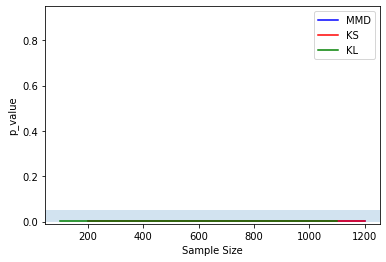

In [8]:
plt.plot(sample_diffDist,p_value_MMD_diffDist,color='blue',label='MMD')
plt.plot(sample_diffDist,p_value_KS_diffDist,color='red',label='KS')
plt.plot(sample_diffDist_KL,p_value_KL_diffDist,color='green',label='KL')
plt.axhspan(0., 0.05, alpha=0.2)
plt.xlabel('Sample Size')
plt.ylabel('p_value')
plt.ylim([-.01,.95])
plt.legend(loc='upper right')

We see what we expect. All three tests are able to see that the data sets were drawn from two different distributions.

##Comparing Two Astronomical Data Sets

Here I use the MMD test to compare to astronomical data sets. They describe the optical richness of red luminous galaxies at different redshifts. Originally, the paper compared data from DES and SDSS. I was not able to access the SDSS data, so I compared DES science verification data sets.

In [13]:
def RM_clusters_witness_function():

    import numpy as np
    from astropy.io import fits
    import matplotlib.pyplot as plt
    from sklearn.metrics import pairwise_distances
    from tatter import two_sample_test, test_statistics, witness_function
    import os

    data_path = "/content/gdrive/MyDrive/tatter-master/"
    plot_path = '/content/gdrive/MyDrive/tatter-master/'
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)


    plt.figure(figsize=(12, 12))

    for i in range(4):

        zmin = 0.2 + 0.05*i
        zmax = 0.2 + 0.05*(i+1)

        # load the datasets
        RM_SDSS = fits.open(data_path+'redmapper_sva1-expanded_public_v6.3_catalog.fits')[1].data
        RM_SV = fits.open(data_path+'redmapper_sva1_public_v6.3_catalog.fits')[1].data

        # apply a redshift and richness cut
        RM_SDSS = RM_SDSS[RM_SDSS.Z_LAMBDA >= zmin]
        RM_SDSS = RM_SDSS[RM_SDSS.Z_LAMBDA < zmax]
        RM_SDSS = RM_SDSS[RM_SDSS.LAMBDA > 20]

        RM_SV = RM_SV[RM_SV.Z_LAMBDA >= zmin]
        RM_SV = RM_SV[RM_SV.Z_LAMBDA < zmax]
        RM_SV = RM_SV[RM_SV.LAMBDA > 20]

        # map richness into a log space
        RM_SDSS.LAMBDA = np.log(RM_SDSS.LAMBDA)
        RM_SV.LAMBDA = np.log(RM_SV.LAMBDA)

        # make a numpy array
        SDSS = np.array(RM_SDSS.LAMBDA)[:, np.newaxis]
        SV = np.array(RM_SV.LAMBDA)[:, np.newaxis]

        # compute the hyper-parameter
        sigma2 = np.median(pairwise_distances(SDSS, SV, metric='euclidean')) ** 2 * 2.0

        # estimate the null distribution and p-value of MMD^2_u test.
        grid = np.linspace(np.log(20), np.log(100), 1001)[:, np.newaxis]
        wf = witness_function(SV, SDSS, grid, kernel_function='rbf', gamma=1.0 / sigma2)

        ax = plt.subplot(2, 2, i+1)
        plt.plot(np.exp(grid), wf, color='black', lw=2.0)

        plt.xlim([20, 100])
        plt.title('$ %0.2f \leq z < %0.2f$'%(zmin, zmax), size=14)

        if i%2 == 0: ax.set_ylabel('witness function', size=22)
        if i > 1: ax.set_xlabel(r'$\lambda_{\rm RM}$', size=22)

    plt.savefig(plot_path + 'SDSS-vs-SV-witness-function.pdf', bbox_inches='tight')


def RM_clusters_consistency_check():

    import numpy as np
    from astropy.io import fits
    from tatter import two_sample_test
    import matplotlib.pyplot as plt
    from sklearn.metrics import pairwise_distances
    import os

    plt.figure(figsize=(12, 12))

    data_path = "/content/gdrive/MyDrive/tatter-master/"
    plot_path = '/content/gdrive/MyDrive/tatter-master/'
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)

    # if cluster catalogs does noe exists download them
    #if_RM_clusters_exists()

    for i in range(4):

        zmin = 0.2 + 0.05*i
        zmax = 0.2 + 0.05*(i+1)

        # load the datasets
        RM_SDSS = fits.open(data_path+'redmapper_sva1-expanded_public_v6.3_catalog.fits')[1].data
        RM_SV = fits.open(data_path+'redmapper_sva1_public_v6.3_catalog.fits')[1].data

        # apply a redshift cut
        RM_SDSS = RM_SDSS[RM_SDSS.Z_LAMBDA >= zmin]
        RM_SDSS = RM_SDSS[RM_SDSS.Z_LAMBDA < zmax]

        RM_SV = RM_SV[RM_SV.Z_LAMBDA >= zmin]
        RM_SV = RM_SV[RM_SV.Z_LAMBDA < zmax]

        # map richness into a log space
        RM_SDSS.LAMBDA = np.log(RM_SDSS.LAMBDA)
        RM_SV.LAMBDA = np.log(RM_SV.LAMBDA)

        # normalize richness -- (x - x.median) / x.std
        std = np.std(RM_SDSS.LAMBDA); med = np.median(RM_SDSS.LAMBDA)

        RM_SV.LAMBDA = (RM_SV.LAMBDA - med) / std
        RM_SDSS.LAMBDA = (RM_SDSS.LAMBDA - med) / std

        # normalize redshift -- (x - x.median) / x.std
        std = np.std(RM_SDSS.Z_LAMBDA); med = np.median(RM_SDSS.Z_LAMBDA)

        RM_SV.Z_LAMBDA = (RM_SV.Z_LAMBDA - med) / std
        RM_SDSS.Z_LAMBDA = (RM_SDSS.Z_LAMBDA - med) / std

        # make a numpy array
        SDSS = np.array([RM_SDSS.LAMBDA, RM_SDSS.Z_LAMBDA]).T
        SV = np.array([RM_SV.LAMBDA, RM_SV.Z_LAMBDA]).T

        # compute the hyper-parameter
        sigma2 = np.median(pairwise_distances(SDSS, SV, metric='euclidean')) ** 2 * 2.0
        # estimate the null distribution and p-value of MMD^2_u test.
        mmd2u, mmd2u_null, p_value = two_sample_test(SDSS, SV, model='MMD',
                                                     kernel_function='rbf', gamma=1.0/sigma2,
                                                     iterations=500, verbose=True, n_jobs=4)

        ax = plt.subplot(2, 2, i+1)
        prob, bins, patches = ax.hist(mmd2u_null, range=(-0.1, 0.03), bins=100)
        if p_value <= 0.001:
            plt.plot(mmd2u, prob.max() / 25, 'wv', markersize=22, markeredgecolor='k',
                     markeredgewidth=2, label='$MMD^2_u$ ($p$-value < %0.3f)'%p_value)
        else:
            plt.plot(mmd2u, prob.max() / 25, 'wv', markersize=22, markeredgecolor='k',
                     markeredgewidth=2, label='$MMD^2_u$ ($p$-value = %0.3f)'%p_value)
        plt.xlim([-0.1, 0.03])
        plt.title('$ %0.2f \leq z < %0.2f$'%(zmin, zmax), size=14)

        if i%2 == 0: ax.set_ylabel('$PDF$', size=22)
        if i > 1: ax.set_xlabel('$MMD^2_u$', size=22)
        plt.legend(numpoints=1, prop={'size':14})

    plt.savefig(plot_path + 'SDSS-vs-SV.pdf', bbox_inches='tight')

#, normed=False

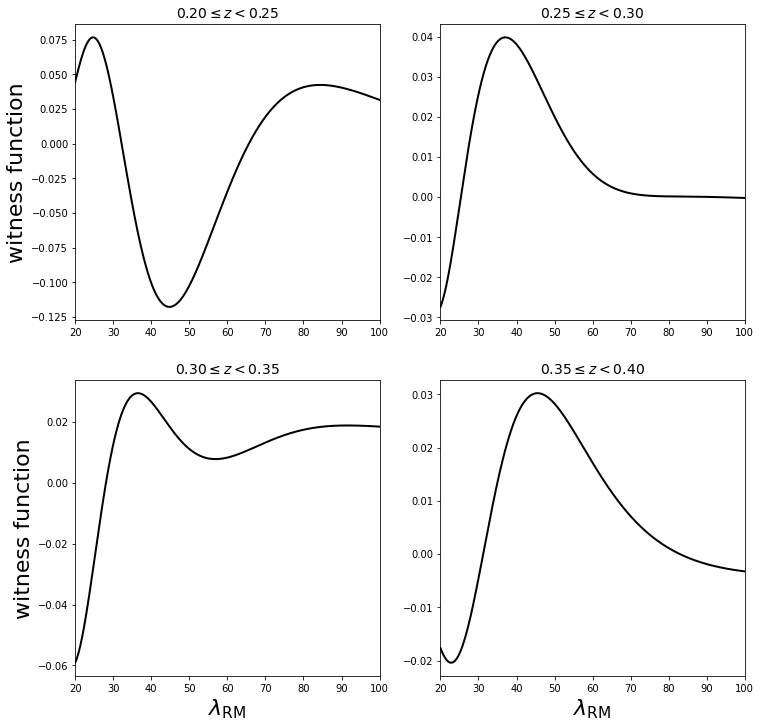

In [14]:
RM_clusters_witness_function()

test value = -0.017468029264800622
Computing the null distribution.


100%|██████████| 500/500 [00:00<00:00, 3644.60it/s]

p-value ~= 0.93 	 (resolution : 0.002)


test value = -0.00981071629587893
Computing the null distribution.


100%|██████████| 500/500 [00:00<00:00, 2730.97it/s]

p-value ~= 0.9460000000000001 	 (resolution : 0.002)


test value = -0.01578432660769402
Computing the null distribution.


100%|██████████| 500/500 [00:00<00:00, 3452.20it/s]

p-value ~= 0.982 	 (resolution : 0.002)


test value = -0.004602122966919087
Computing the null distribution.


100%|██████████| 500/500 [00:00<00:00, 1962.96it/s]


p-value ~= 0.744 	 (resolution : 0.002)


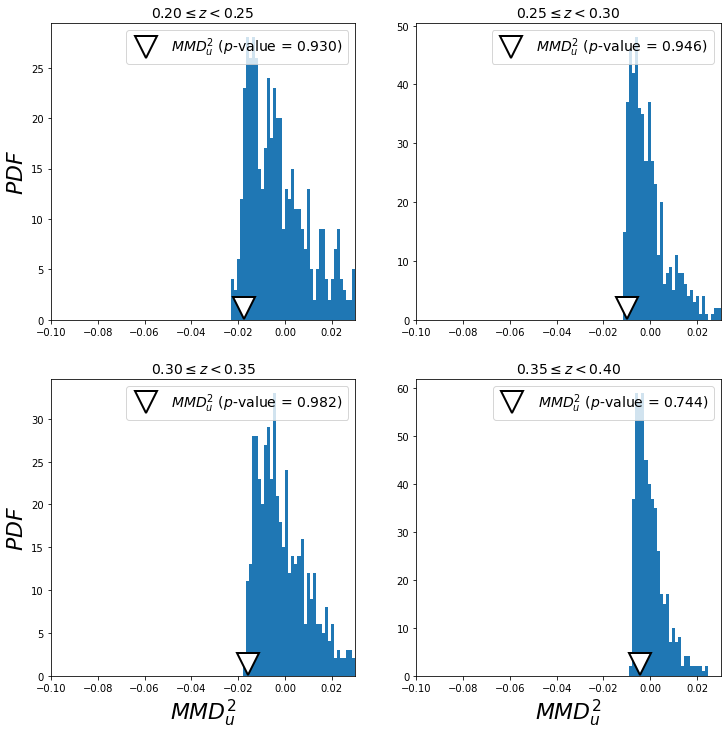

In [26]:
RM_clusters_consistency_check()